In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
from tqdm import tqdm
import os
import json

%load_ext autoreload
%autoreload 2

In [2]:
station_dir = "./all/"

In [10]:
with open("data/metadata.json") as f:
    metadata = json.loads(f.read())

In [43]:
start_date = np.datetime64("2018-01-01")  # sometimes there's data from just before jan 1 2018, let's ignore that
fs = [s for s in os.listdir(station_dir) if s.endswith(".csv")]
for i, station_fname in tqdm(enumerate(fs), total=len(fs)):
    if station_fname not in metadata:
        metadata[station_fname] = dict()
    if station_fname.startswith("obs"):
        pathname = os.path.join(station_dir, station_fname)
        df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
        df = df[df.ISO8601 >= start_date]
        df = df[df.obstype=='no2']
        if len(df) == 0:
            metadata[station_fname] = dict(obs=station_fname.startswith("obs"), n_data=0, quality=np.nan, lat=np.nan, lon=np.nan, mean=np.nan, std=np.nan, max=np.nan, min=np.nan)
            continue
        metadata[station_fname]["obs"] = True
        metadata[station_fname]["mean"] = df.conc_obs.mean()
        metadata[station_fname]["std"] = df.conc_obs.std()
        metadata[station_fname]["max"] = df.conc_obs.max()
        metadata[station_fname]["min"] = df.conc_obs.min()

    if station_fname.startswith("model_forecast"):
        pathname = os.path.join(station_dir, station_fname)
        df = pd.read_csv(pathname, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
        df.ISO8601 -= dt.timedelta(minutes=30)  # the timestamps in mod were misaligned
        df = df[df.ISO8601 >= start_date]
        if len(df) == 0:
            metadata[station_fname] = dict(obs=station_fname.startswith("obs"), n_data=0, quality=np.nan, lat=np.nan, lon=np.nan, mean=np.nan, std=np.nan, max=np.nan, min=np.nan)
            continue
        metadata[station_fname]["obs"] = False
        metadata[station_fname]["mean"] = df.NO2.mean()
        metadata[station_fname]["std"] = df.NO2.std()
        metadata[station_fname]["max"] = df.NO2.max()
        metadata[station_fname]["min"] = df.NO2.min()
        
    metadata[station_fname]["n_data"] = len(df)
    metadata[station_fname]["quality"] = len(df) / ((df.ISO8601.iloc[-1] - df.ISO8601.iloc[0]).days * 24 + 23)
    metadata[station_fname]["lat"] = df.iloc[0].lat
    metadata[station_fname]["lon"] = df.iloc[0].lon
    if i % 100 == 0:
        with open("data/metadata.json", "w") as f:
            f.write(json.dumps(metadata))



100%|██████████| 16546/16546 [05:35<00:00, 49.26it/s] 


In [44]:
with open("data/metadata.json", "w") as f:
    f.write(json.dumps(metadata))

# cluster the points

In [45]:
from sklearn.cluster import DBSCAN

In [46]:
quality_thresh = 0.5

In [79]:
obs_thresh = 20
len([s["mean"] for s in metadata.values() if s["obs"] and s["mean"] > obs_thresh])

664

In [141]:
wuhan = [[30.59], [114.31]]  # Wuhan: 30.5928° N, 114.3052° E
milan = [[45.46], [9.19]]  # Italy: 45.4642° N, 9.1900° E
kansas = [[39.01], [98.48]]  # Kansas: 39.0119° N, 98.4842° W
seattle = [[47.61], [-122.33]]  # 47.6062° N, 122.3321° W
losangeles = [[34.05], [-118.24]]  # 34.0522° N, 118.2437° W
region_centers = {"wuhan": wuhan, "losangeles": losangeles, "milan": milan}
regions = dict()
for region in region_centers.keys():
    regions[region] = dict()
    for station_fname in metadata.keys():
        lat = metadata[station_fname]["lat"]
        lon = metadata[station_fname]["lon"]
        if (lat - region_centers[region][0][0])**2 + (lon - region_centers[region][1][0])**2 < 2**2:
            regions[region][station_fname] = metadata[station_fname]

coords = np.array([[s["lat"], s["lon"]] for s in metadata.values() if s["obs"] and s["quality"] > quality_thresh and s["mean"] > obs_thresh]) 
clustering = DBSCAN(eps=10, min_samples=4).fit(coords)
labs = np.unique(clustering.labels_)
labs

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [142]:
[(r, len(regions[r])) for r in regions]

[('wuhan', 92), ('losangeles', 88), ('milan', 456)]

wuhan (7, 2)
losangeles (3, 2)
milan (17, 2)


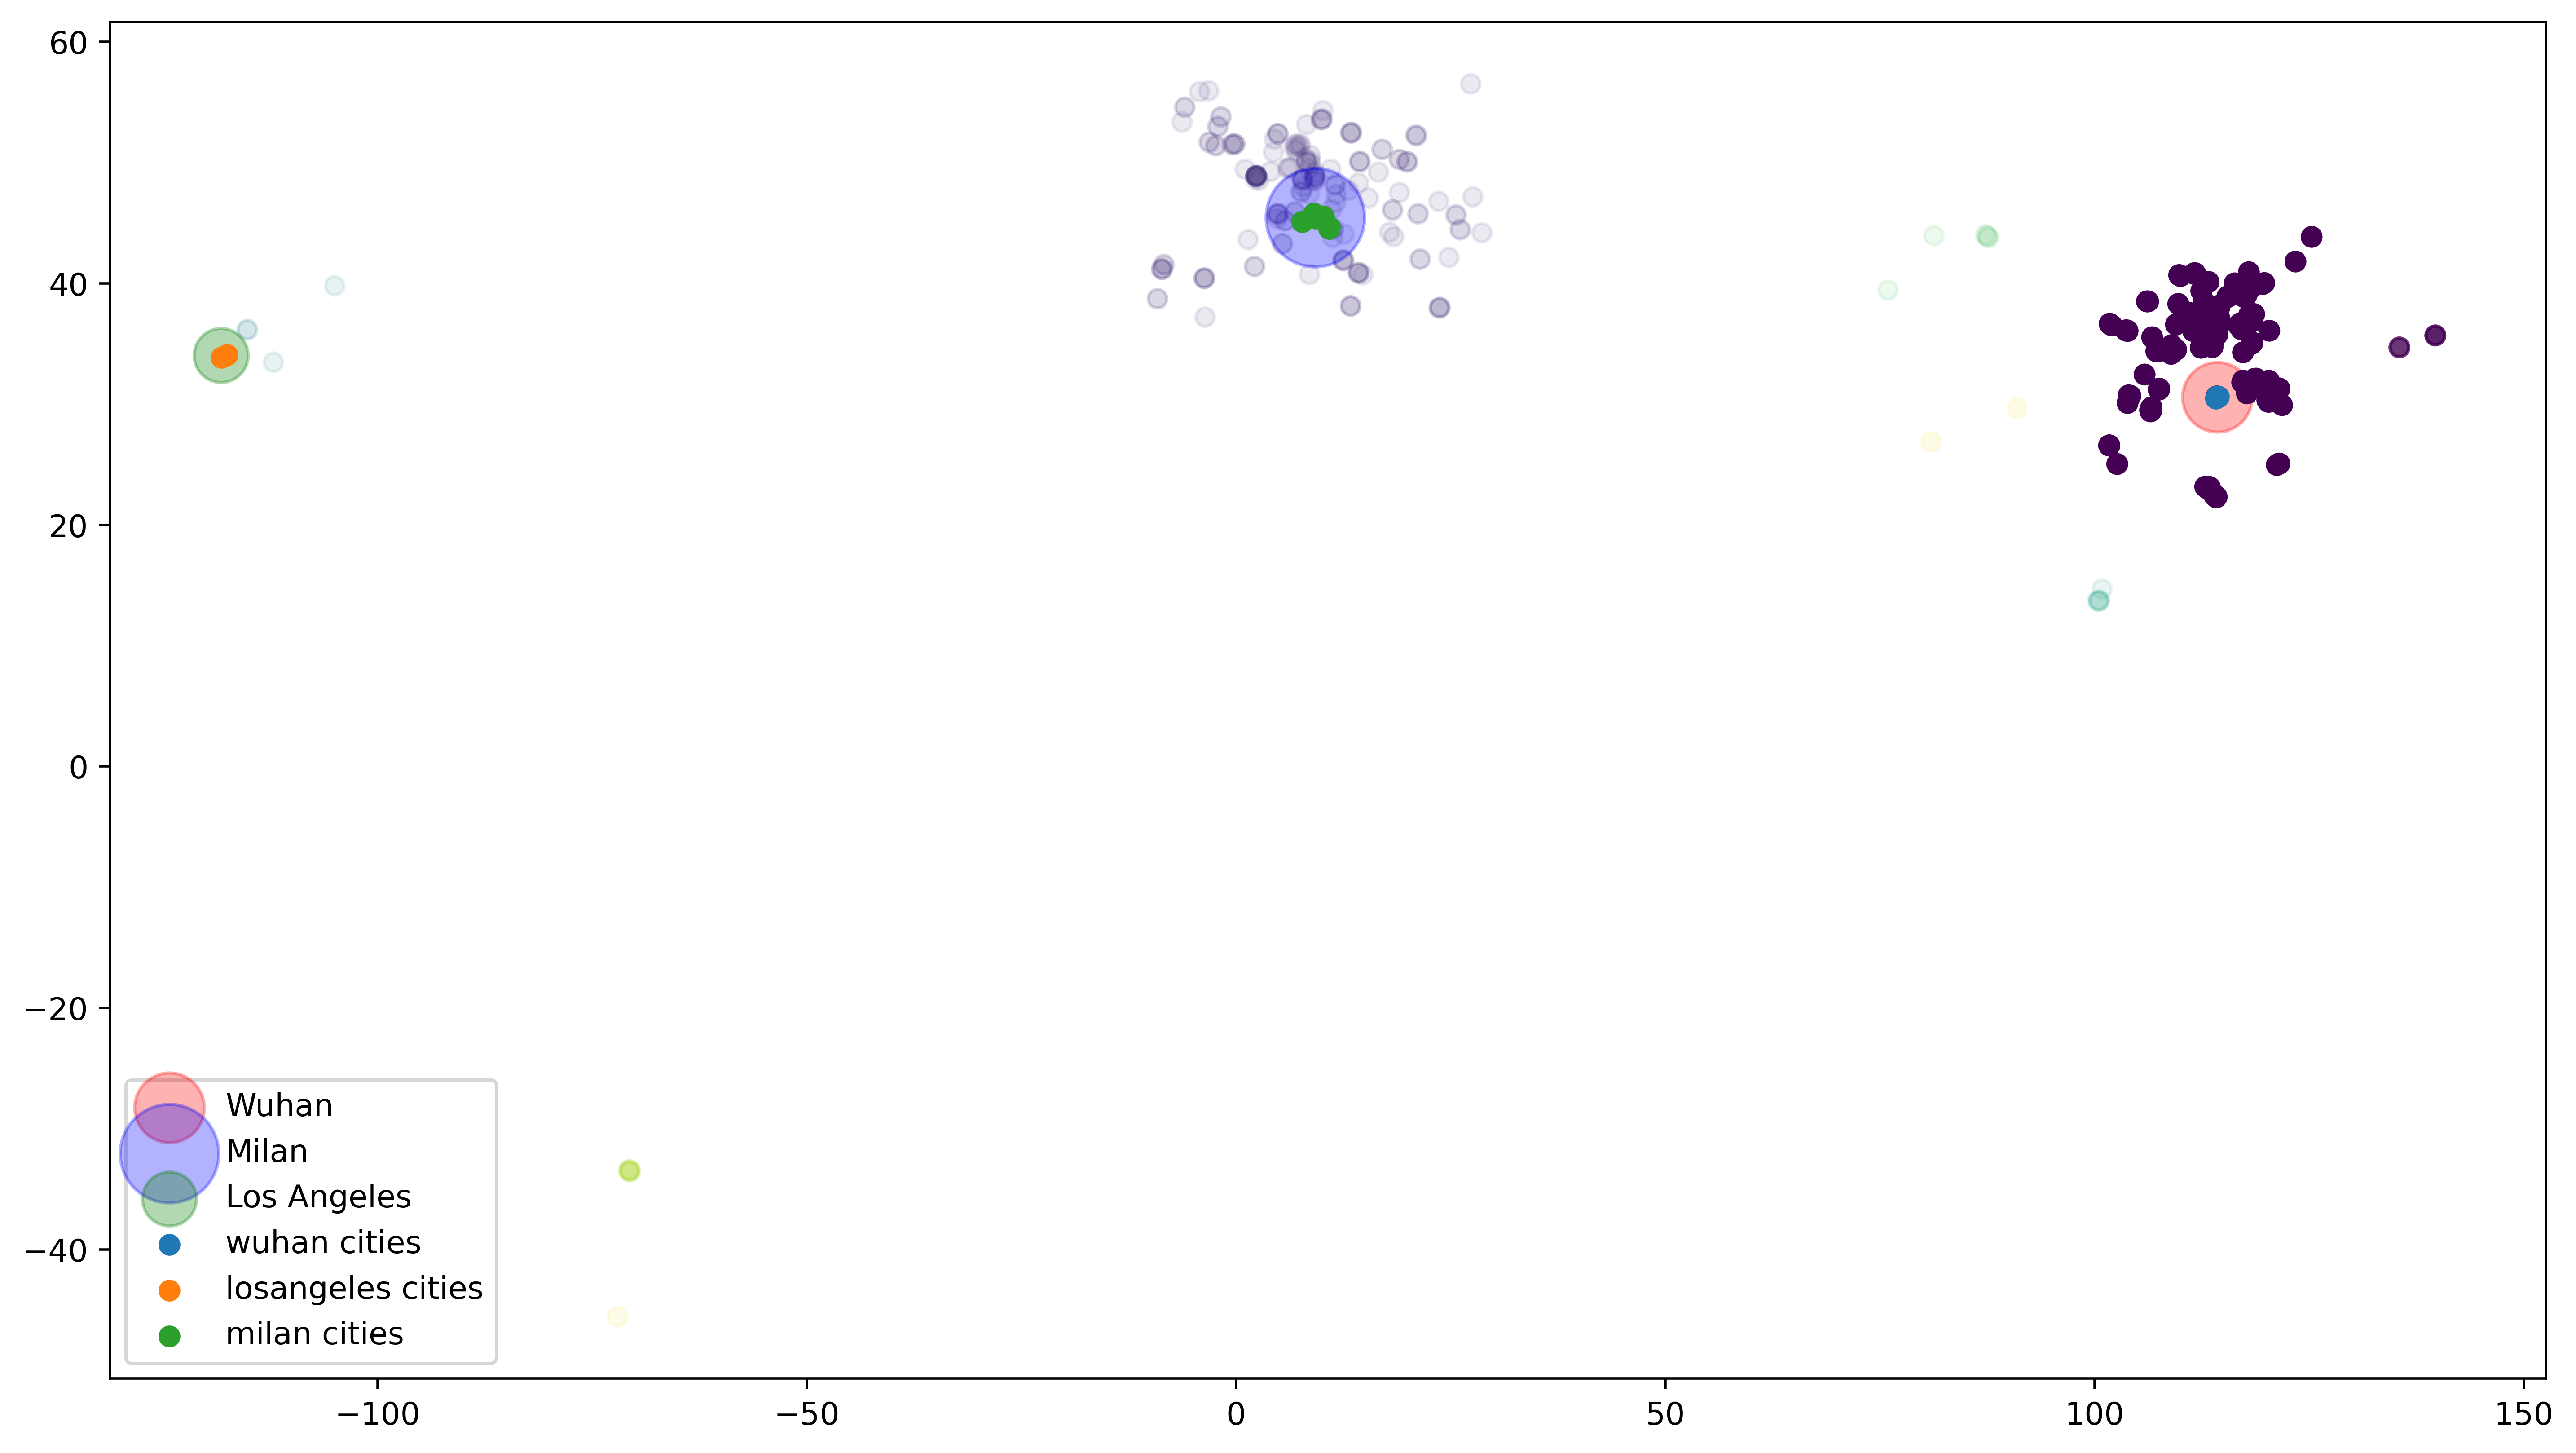

In [143]:

plt.figure(dpi=500, figsize=[14, 8])
colors = (100 * clustering.labels_) % 47
plt.scatter(coords[:, 1], coords[:, 0], c=colors, alpha=0.1)
i=2
plt.scatter(wuhan[1], wuhan[0], s=500, c="red", alpha=0.3, label="Wuhan")
plt.scatter(milan[1], milan[0], s=1000, c="blue", alpha=0.3, label="Milan")
plt.scatter(losangeles[1], losangeles[0], s=300, c="green", alpha=0.3, label="Los Angeles")
plt.scatter(coords[clustering.labels_ == i, 1], coords[clustering.labels_ == i, 0], c=colors[clustering.labels_ == i])
for region in regions.keys():
    c = np.array([[s["lat"], s["lon"]] for s in regions[region].values() if s["obs"] and s["quality"] > quality_thresh and s["mean"] > obs_thresh])
    print(region, c.shape)
    plt.scatter(c[:, 1], c[:, 0], label=region + " cities")
plt.legend()
plt.show()

In [145]:
for region in regions:
    for station_fname in regions[region].keys():
        s = regions[region][station_fname]
        if s["obs"] and s["quality"] > quality_thresh and s["mean"] > obs_thresh:
            station_name = station_fname[4:-4]
            mod_fname = f"model_forecast_{station_name}.csv"

            metadata[mod_fname]["station"] = station_name
            metadata[station_fname]["station"] = station_name
            metadata[mod_fname]["clusters"] = metadata[mod_fname].get("clusters", []) + [region]
            metadata[station_fname]["clusters"] = metadata[station_fname].get("clusters", []) + [region]

In [146]:

# cluster_id_offset = np.int32(time.time()) # so it doesn't duplicate old cluster labels by e.g. adding the current time in seconds to the cluster ids
# i = 0 
# for station_fname in metadata:
#     if metadata[station_fname]["obs"] and metadata[station_fname]["quality"] > quality_thresh:
#         station_name = station_fname[4:-4]
#         mod_fname = f"model_forecast_{station_name}.csv"

#         metadata[mod_fname]["station"] = station_name
#         metadata[station_fname]["station"] = station_name
#         metadata[mod_fname]["clusters"] = metadata[mod_fname].get("clusters", []) + [int(clustering.labels_[i] + cluster_id_offset)]
#         metadata[station_fname]["clusters"] = metadata[station_fname].get("clusters", []) + [int(clustering.labels_[i] + cluster_id_offset)]
#         i += 1


In [147]:
for station_fname in metadata:
    if "clusters" not in metadata[station_fname].keys():
        metadata[station_fname]["clusters"] = []

In [148]:
with open("data/metadata.json", "w") as f:
    f.write(json.dumps(metadata))

# Anomaly detection for a particular region

In [7]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from dpk.koopman_probabilistic import KoopmanProb
from dpk.model_objs import NormalNLL

[ Using Seed :  633  ]


In [230]:
with open("data/metadata.json") as f:
    metadata = json.loads(f.read())

cluster_id = 3
temp = []
for fname in metadata:
    temp.append(metadata[fname])
    temp[-1]["fname"] = fname
df_meta = pd.DataFrame(temp)
stations = df_meta.loc[[(cluster_id in r.clusters and r.quality > quality_thresh) for r in df_meta.iloc]].station.unique()

In [231]:
station_path = "./all/"
data_type = "obs"  # "model_forecast"

### Collect the data for the stations in this cluster, preprocess/take log, and put into multidim array
- run a separate DPK for each station (mod and obs)
- find zeta time series for each
- put these into multidim array gapfilled to do PCA
    - maybe I don't even need to gapfill if theres enough datapoints where all stations have data? gapfilling might give weird pca results
- take top few PCs joint distribution
    - should have 0 correlation, but not necessarily *statistically* independent
    - i might still be able to make this independence assumption after looking at the distribution
- P(PC 1) * P(PC 2) * ... * P(PC 3 or something) ~= P(zeta)

In [232]:
def get_z_scores(x, t, koop):
    params = koop.predict(t, covariates=t.reshape(len(t), 1))
    mean_hat = koop.model_obj.mean(params)
    std_hat = koop.model_obj.std(params)
    z_scores = (x - mean_hat) / std_hat
    return z_scores

def get_contiguous_k_samples(k, series):
    if len(series) < k:
        return np.zeros((0, k))
    k_samples = np.zeros((len(series) - k + 1, k))
    for i in range(0, len(series) - k + 1):
        sample = series[i:i+k]
        k_samples[i, :] = sample.flatten()

    return k_samples

In [588]:
import pickle
from scipy.stats import norm
from scipy import interpolate
import time

k = 24 * 7
alpha = 0.001  # 0.05 / num hypothesese

# make sure these match the data
train_start_date = dt.datetime(2018, 1, 1) # dt.datetime(2018, 3, 16)
train_end_date = dt.datetime(2019, 10, 1) # dt.datetime(2020, 3, 16)  # covid start date
test_end_date = dt.datetime(2020, 1, 1) # dt.datetime(2020, 5, 16)
t_min = time.mktime(dt.datetime(2018, 1, 1).timetuple())
train_start_t = time.mktime(train_start_date.timetuple()) - t_min
train_end_t = time.mktime(train_end_date.timetuple()) - t_min
test_end_t = time.mktime(test_end_date.timetuple()) - t_min

train_k_averages = []
train_ts = []
test_k_averages = []
test_ts = []
for station in stations:
    # load the koopman model and relevant data for station
    data_name = f"obs_{station}"
    for fname in os.listdir("forecasts"):
        if data_name in fname and fname.startswith("koop"):
            param_str = fname[5:-4]

    obs_koop = pickle.load(open(f"forecasts/koop_{param_str}.pkl", 'rb'))
    obs_x = np.load(f"forecasts/x_{param_str}.npy")
    obs_t = np.load(f"forecasts/t_{param_str}.npy")

    train_start = np.nonzero(obs_t >= train_start_t)[0][0]
    train_end = np.nonzero(obs_t >= train_end_t)[0][0]
    test_end = np.nonzero(obs_t >= test_end_t)[0][0]

    obs_z_scores = get_z_scores(obs_x, obs_t, obs_koop).flatten()

    # model_analys
    data_name =  f"model_forecast_{station}"
    for fname in os.listdir("forecasts"):
            if data_name in fname and fname.startswith("koop"):
                param_str = fname[5:-4]

    mod_koop = pickle.load(open(f"forecasts/koop_{param_str}.pkl", 'rb'))
    mod_x = np.load(f"forecasts/x_{param_str}.npy")
    mod_t = np.load(f"forecasts/t_{param_str}.npy")

    mod_z_scores = get_z_scores(mod_x, mod_t, mod_koop).flatten()

    f = interpolate.interp1d(mod_t, mod_z_scores)
    aligned_mod_z_scores = f(obs_t)
    zeta_scores = obs_z_scores - aligned_mod_z_scores
    train_k_averages.append(get_contiguous_k_samples(k, zeta_scores[train_start:train_end]).mean(axis=1))
    train_ts.append(get_contiguous_k_samples(k, obs_t[train_start:train_end]).mean(axis=1))
    test_k_averages.append(get_contiguous_k_samples(k, zeta_scores[train_end:test_end]).mean(axis=1))
    test_ts.append(get_contiguous_k_samples(k, obs_t[train_end:test_end]).mean(axis=1))


In [589]:
np.nonzero(obs_t >= train_end_t)[0]

array([ 9877,  9878,  9879, ..., 18812, 18813, 18814])

In [590]:
len(stations)

9

In [591]:
plt.figure(dpi=500, figsize=(15, 15))
for i in range(len(stations)):
    plt.subplot(3, 3, i+1)
    norm_crit_l = norm.ppf(alpha, loc=np.mean(train_k_averages[i]), scale=np.std(train_k_averages[i]))
    norm_crit_u = norm.ppf(1-alpha, loc=np.mean(train_k_averages[i]), scale=np.std(train_k_averages[i]))
    plt.hist(train_k_averages[i], bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar z$")
    # plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
    plt.hist(test_k_averages[i], bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar z$")
    plt.axvline(norm_crit_l, color="gray", label="$\\bar z^*$")
    plt.axvline(norm_crit_u, color="gray")
    plt.title(f"{stations[i]}, k={k}")
    plt.xlabel("sample mean z-score")
    l = np.linspace(min(train_k_averages[i]), max(train_k_averages[i]))
    # if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
    plt.plot(l, norm.pdf(l, loc=np.mean(train_k_averages[i]), scale=np.std(train_k_averages[i])), label="normal fit")
plt.legend()
plt.tight_layout()

In [592]:
good_station_idxs = list(range(9))
good_stations = stations[good_station_idxs]
# run PCA on these, after time aligning them

In [593]:
# TODO take min of max t and max of min t
all_train_ts = np.unique(np.concatenate(np.array(train_ts, dtype=object)[good_station_idxs]))
all_test_ts = np.unique(np.concatenate(np.array(test_ts, dtype=object)[good_station_idxs]))
all_train_ts, all_test_ts

(array([  966021.42857143,   982007.14285714,   985971.42857143, ...,
        54807921.42857143, 54809764.28571428, 54811607.14285714]),
 array([55435478.57142857, 55436635.71428572, 55437814.28571428, ...,
        62764114.28571428, 62765571.42857143, 62767735.71428572]))

In [594]:

train_zeta_avg_mat = np.full((len(all_train_ts), len(stations)), fill_value=np.nan)  # [t, dim]
test_zeta_avg_mat = np.full((len(all_test_ts), len(stations)), fill_value=np.nan)  # [t, dim]

for i, station in zip(good_station_idxs, good_stations):
    station_fname = f"obs_{station}.csv"
    print("quality:,", metadata[station_fname]["quality"])

    interp = interpolate.interp1d(train_ts[i], train_k_averages[i], bounds_error=False, fill_value=np.nanmean(train_k_averages[i]))
    train_zeta_avg_mat[:, i] = interp(all_train_ts)

    interp = interpolate.interp1d(test_ts[i], test_k_averages[i], bounds_error=False, fill_value=np.nanmean(test_k_averages[i]))
    test_zeta_avg_mat[:, i] = interp(all_test_ts)

train_zeta_avg_mat = train_zeta_avg_mat[:, good_station_idxs]
test_zeta_avg_mat = test_zeta_avg_mat[:, good_station_idxs]

quality:, 0.8021303484383463
quality:, 0.7220797977974364
quality:, 0.6690738400433291
quality:, 0.7464163206354938
quality:, 0.6701209604621773
quality:, 0.7637479689474634
quality:, 0.8094962989709333
quality:, 0.7918035746524643
quality:, 0.7366672684600108


In [595]:
np.sum(np.isnan(train_zeta_avg_mat))

0

In [596]:
len(good_station_idxs)

9

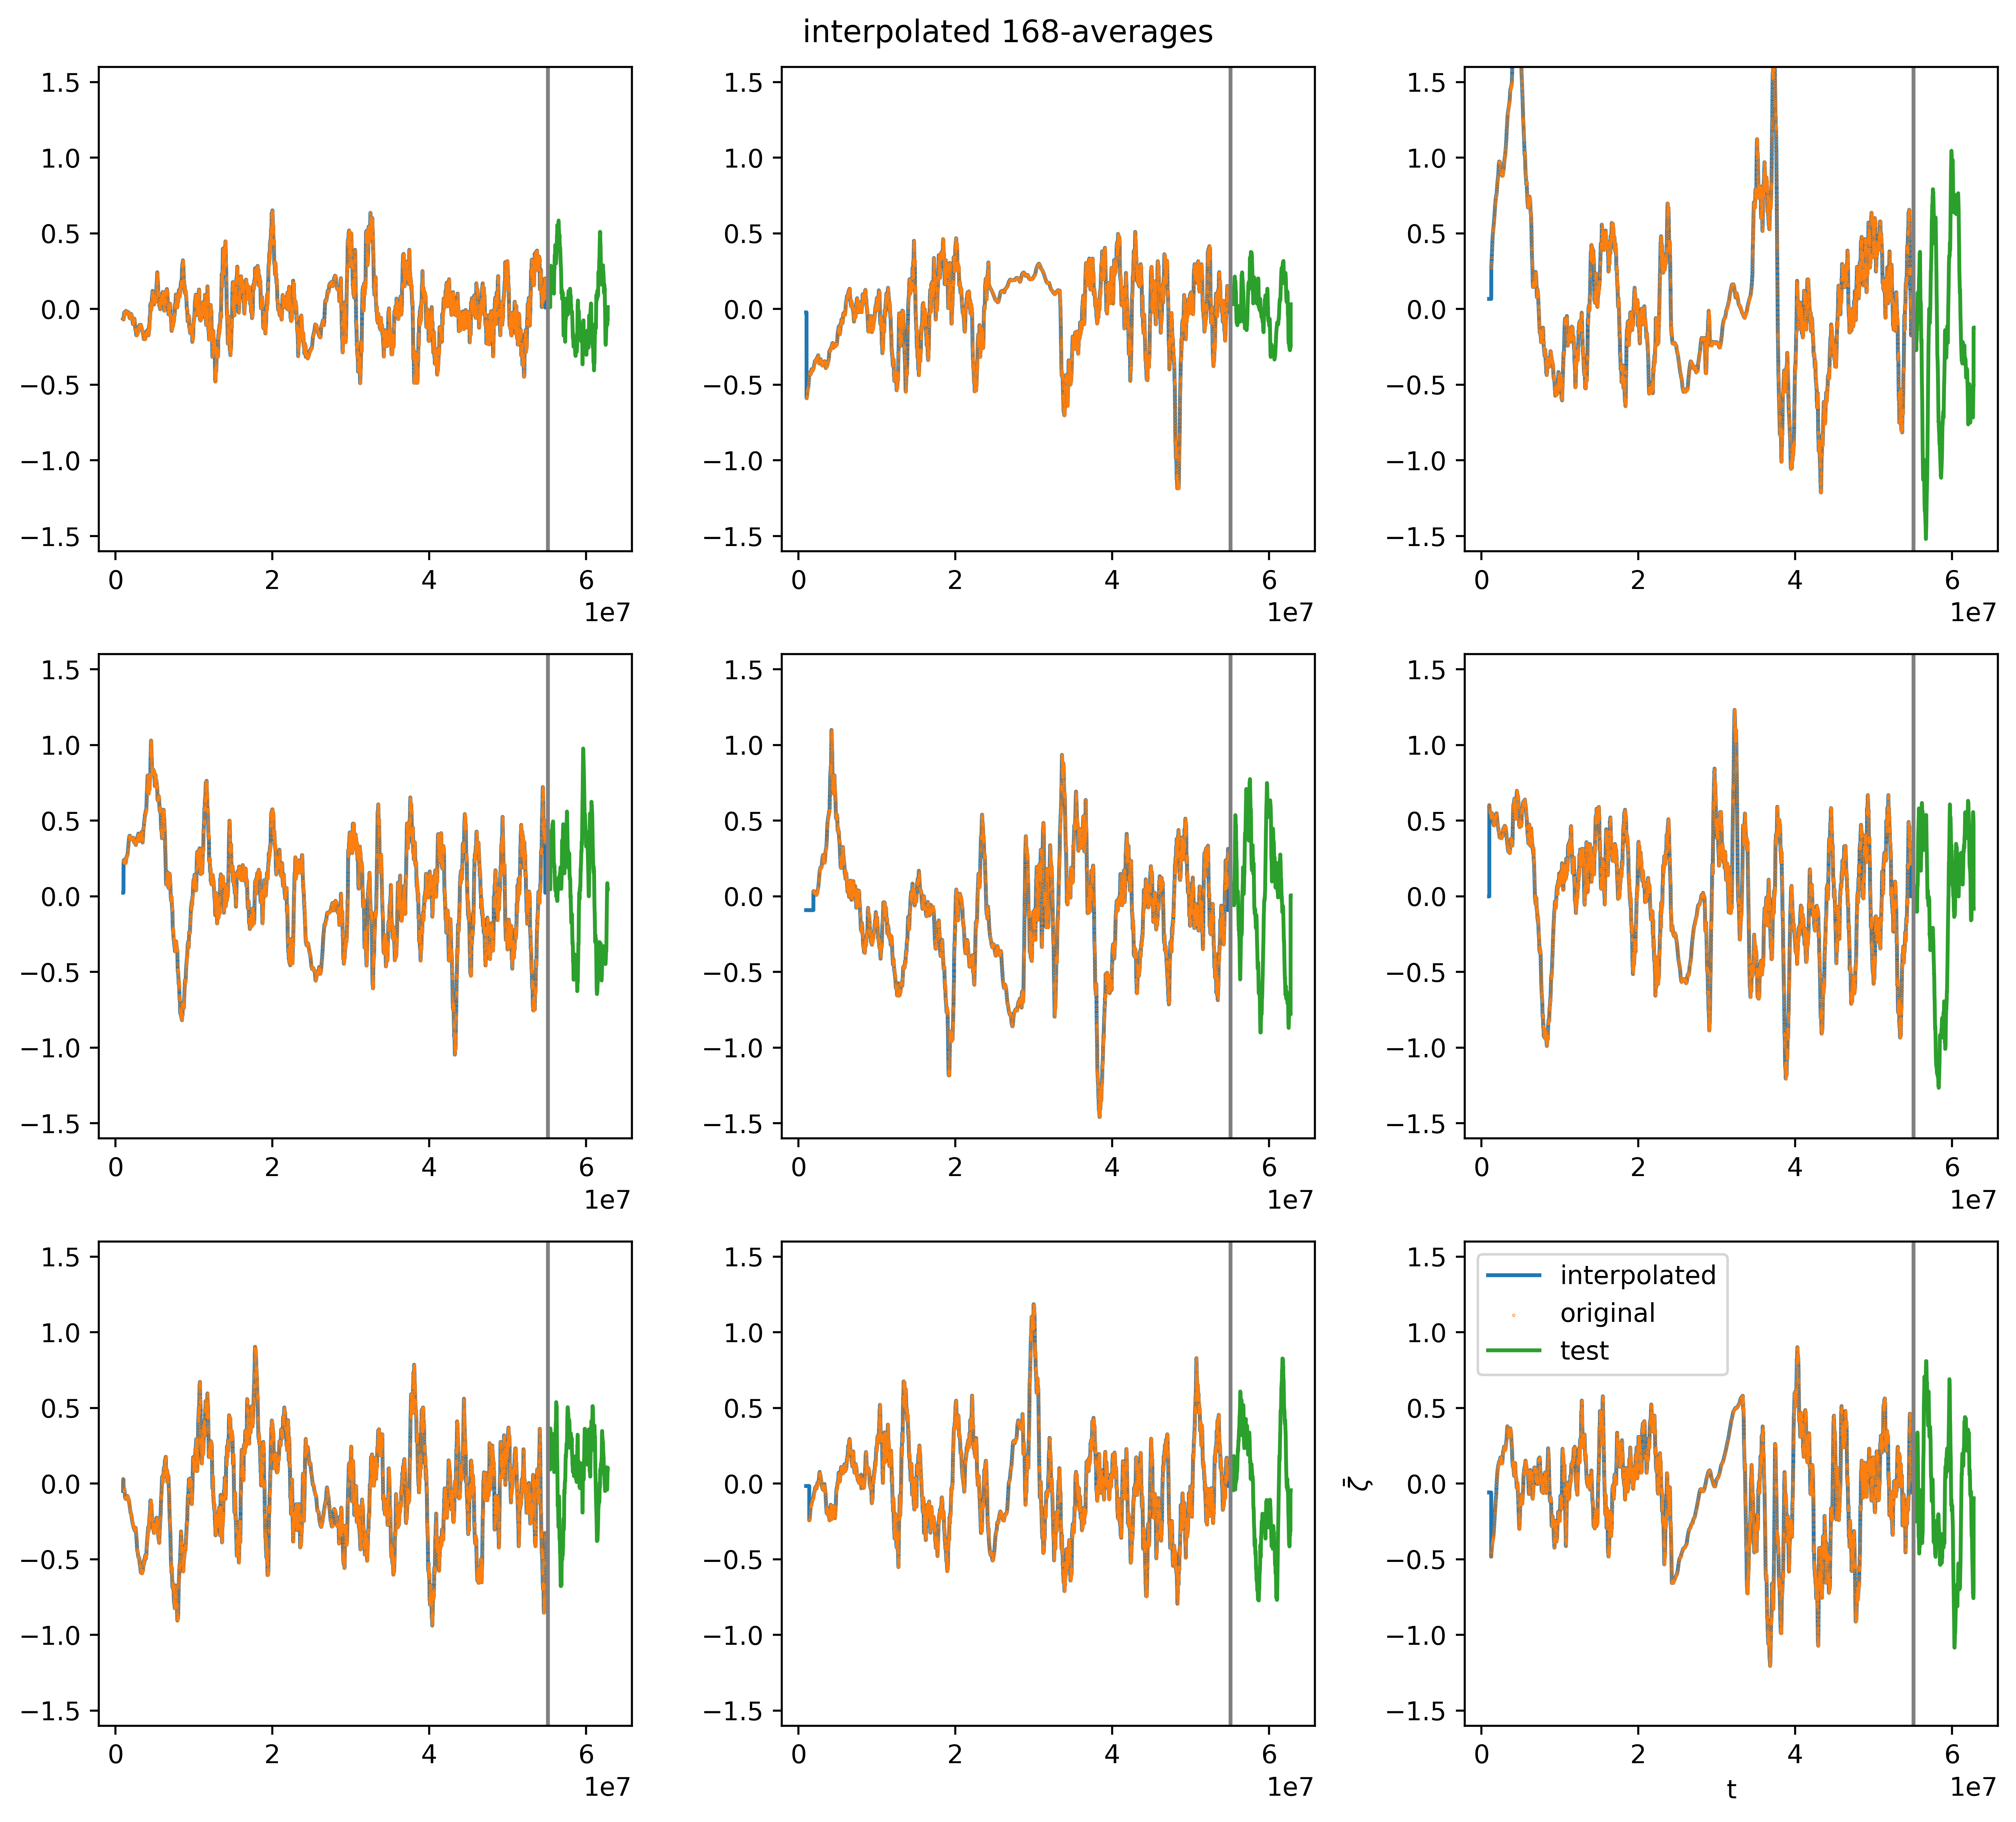

In [597]:
plt.figure(dpi=500, figsize=(11, 10))
for i in range(len(good_stations)):
    plt.subplot(3, 3, i+1)
    plt.plot(all_train_ts, train_zeta_avg_mat[:, i], label="interpolated")
    plt.scatter(train_ts[good_station_idxs[i]], train_k_averages[good_station_idxs[i]], label="original", c="tab:orange", s=0.05, zorder=2)
    plt.plot(all_test_ts, test_zeta_avg_mat[:, i], label="test", color="tab:green")
    plt.ylim([-1.6, 1.6])
    plt.axvline(train_end_t, color="gray")
plt.suptitle(f"interpolated {k}-averages")
plt.xlabel("t")
plt.ylabel("$\\bar \zeta$")
plt.legend()
plt.tight_layout()

In [598]:
stations

array(['Station0004436', 'Station0004091', 'Station0005566',
       'Station0005513', 'Station0005292', 'Station0005390',
       'Station0004701', 'Station0004349', 'Station0004074'], dtype=object)

In [599]:
metadata["obs_Station0005390.csv"]

{'obs': True,
 'n_data': 21152,
 'quality': 0.7637479689474634,
 'lat': 52.9822,
 'lon': -122.4922,
 'station': 'Station0005390',
 'clusters': [3],
 'fname': 'obs_Station0005390.csv'}

In [600]:
from sklearn.decomposition import PCA

In [601]:
pca = PCA()
pca.fit(train_zeta_avg_mat)

PCA()

Text(0, 0.5, 'explained variance')

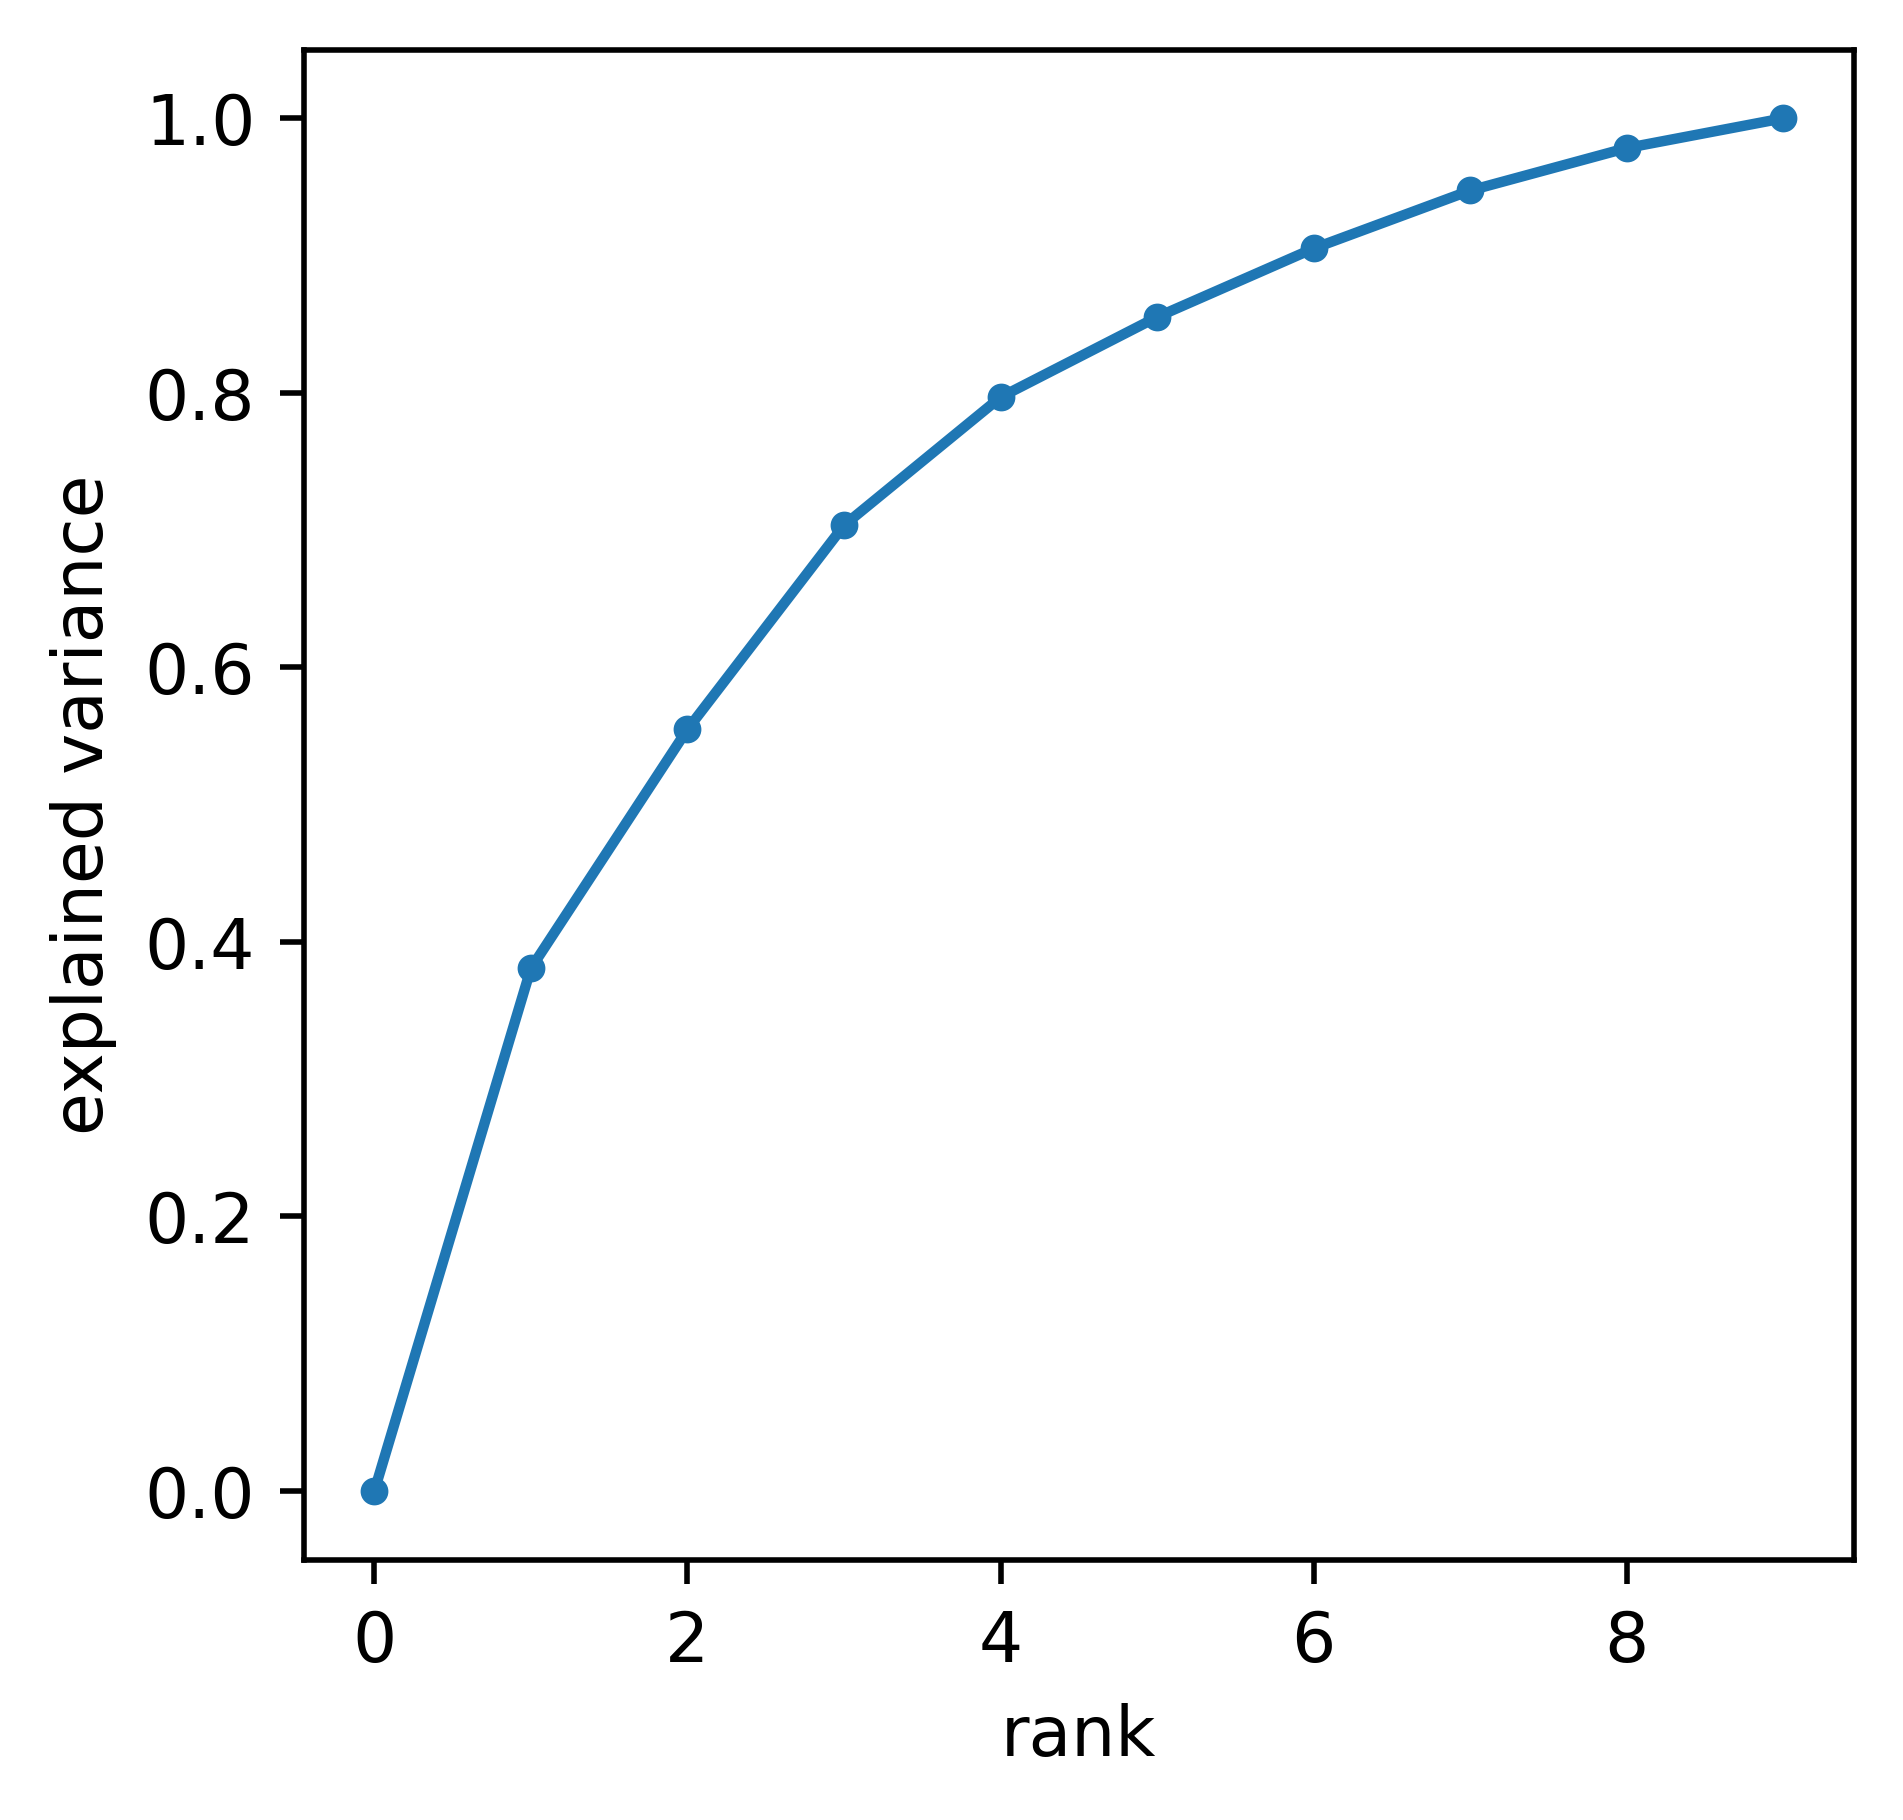

In [602]:
cumul_exp_var = [0] + [sum(pca.explained_variance_ratio_[:i + 1]) for i in range(len(pca.explained_variance_ratio_))]
plt.figure(dpi=500, figsize=(4, 4))
plt.plot(cumul_exp_var, marker=".")
plt.xlabel("rank")
plt.ylabel("explained variance")

In [603]:
train_proj = pca.transform(train_zeta_avg_mat)
test_proj = pca.transform(test_zeta_avg_mat)

Text(0.5, 1.0, 'training data projection')

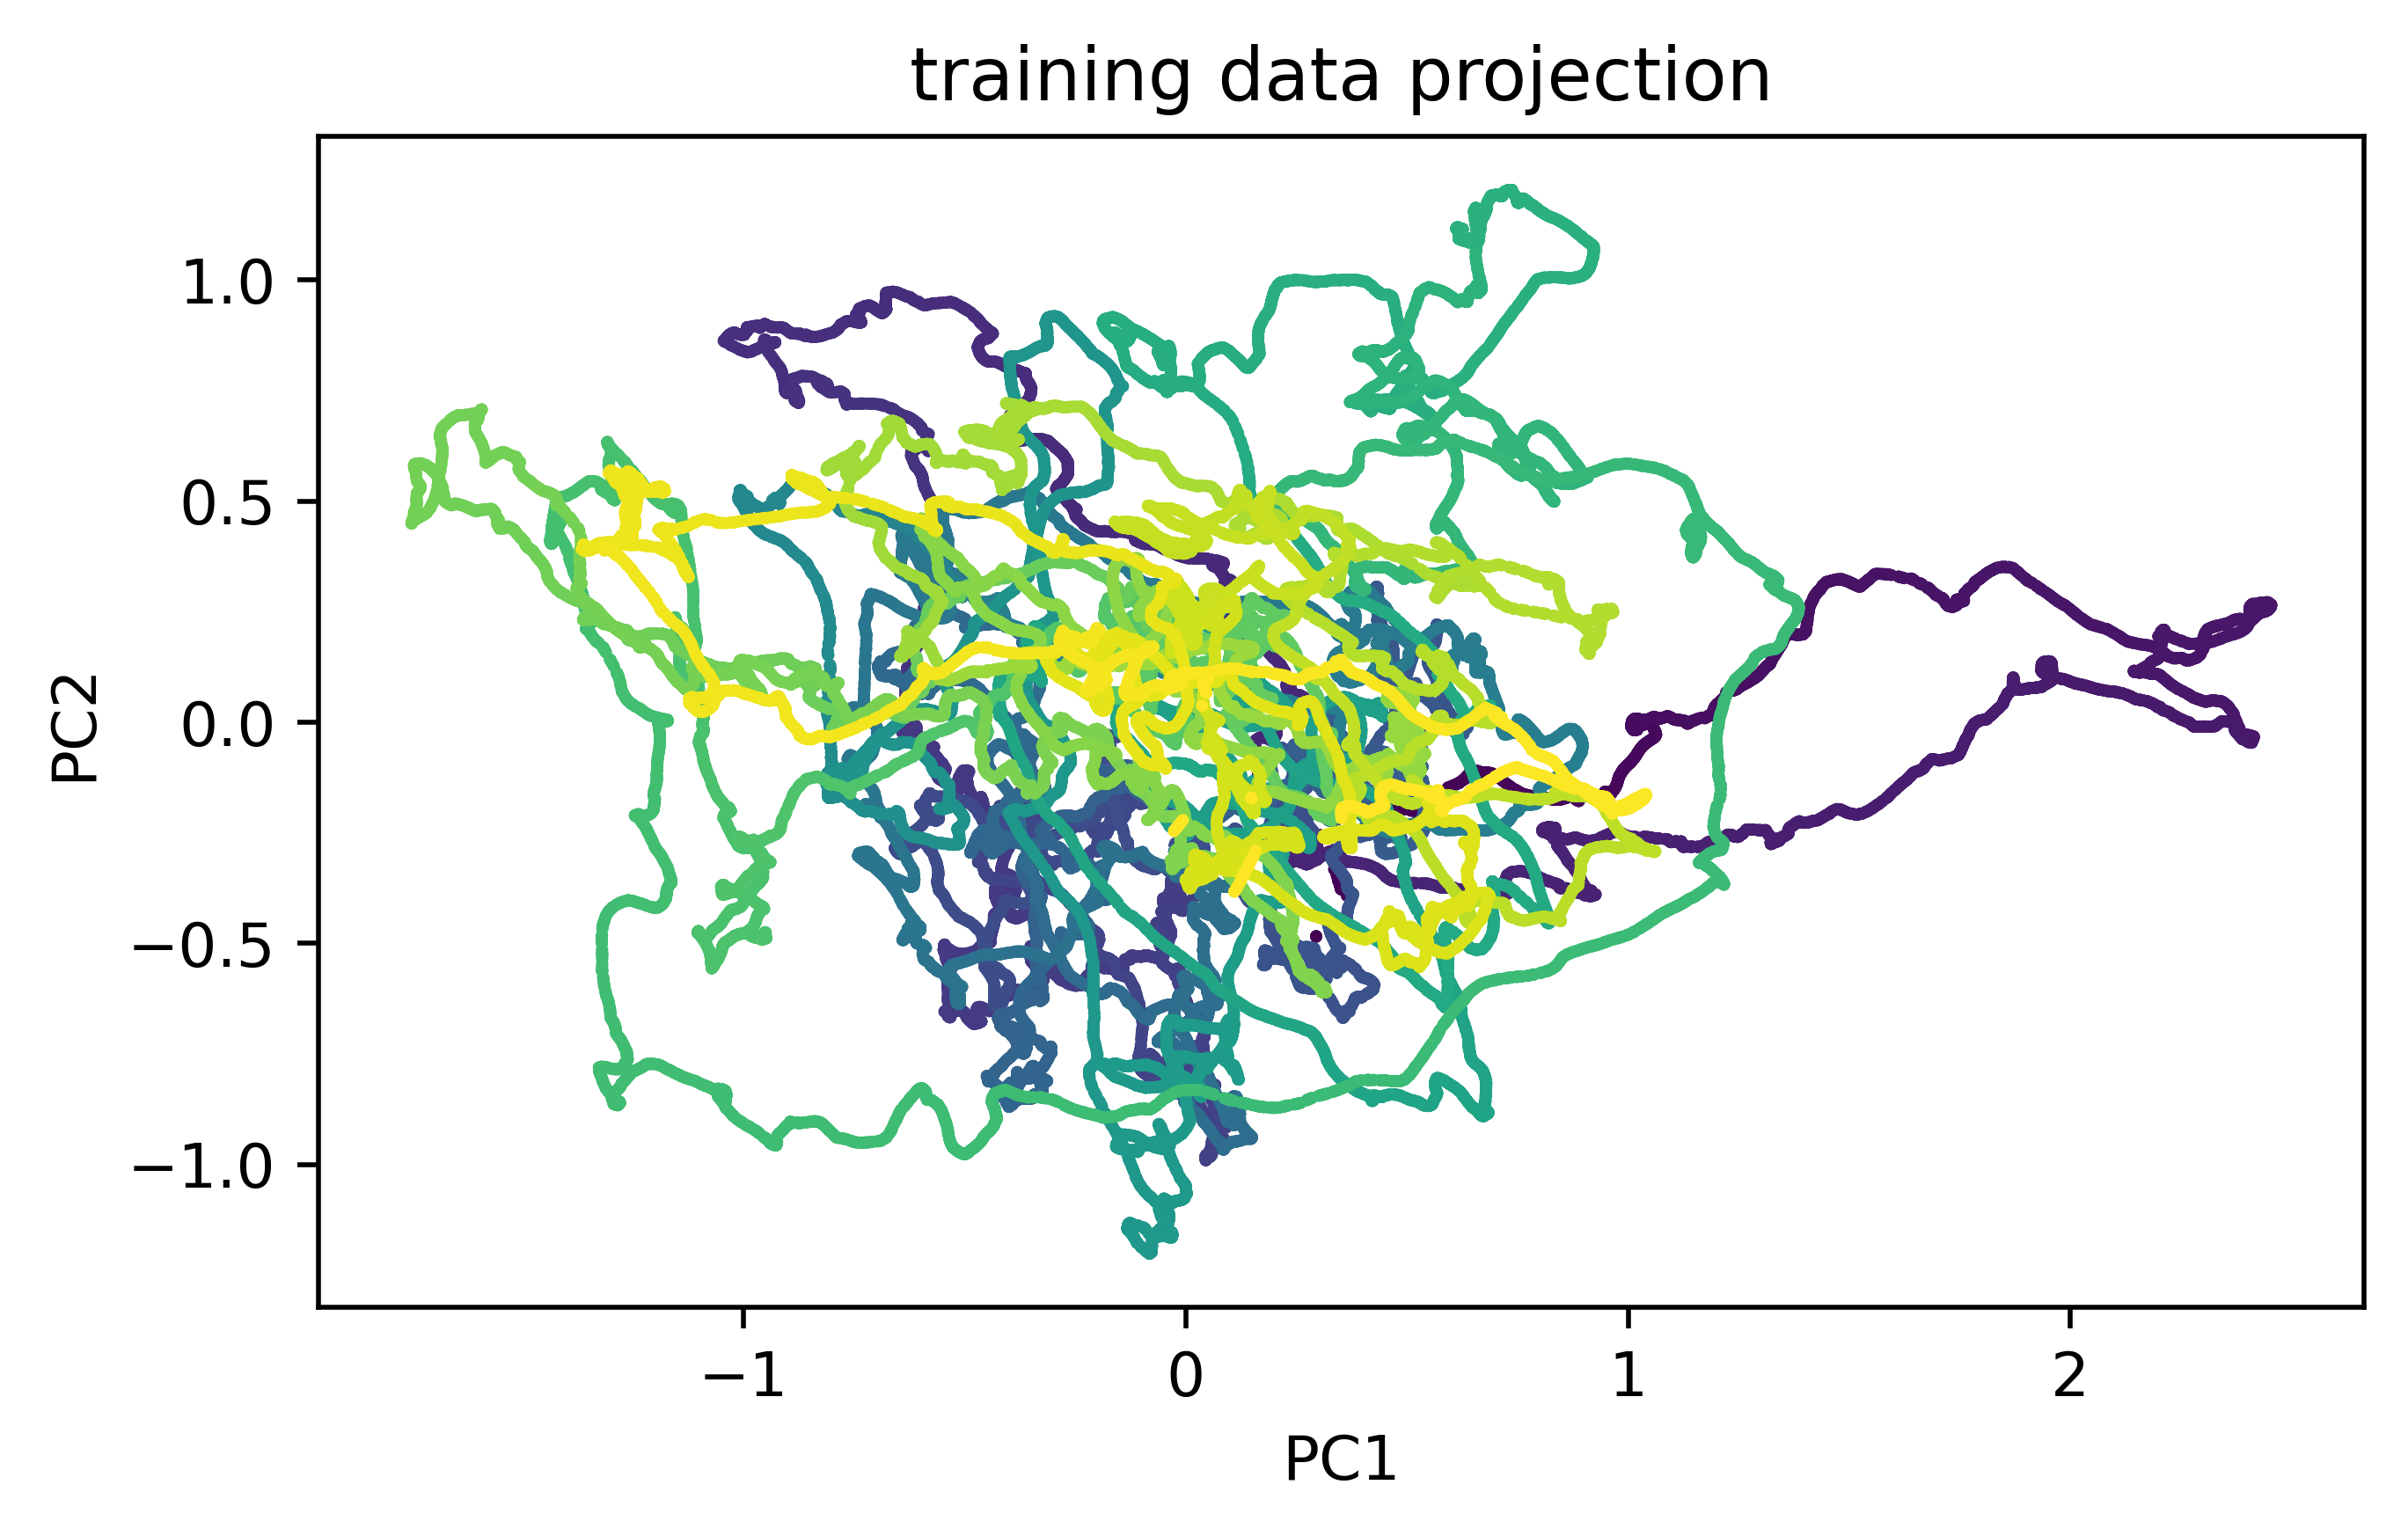

In [604]:
plt.figure(dpi=500)
plt.scatter(train_proj[:, 0], train_proj[:, 1], s=1, c=all_train_ts)
axes = plt.gca()
axes.set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("training data projection")

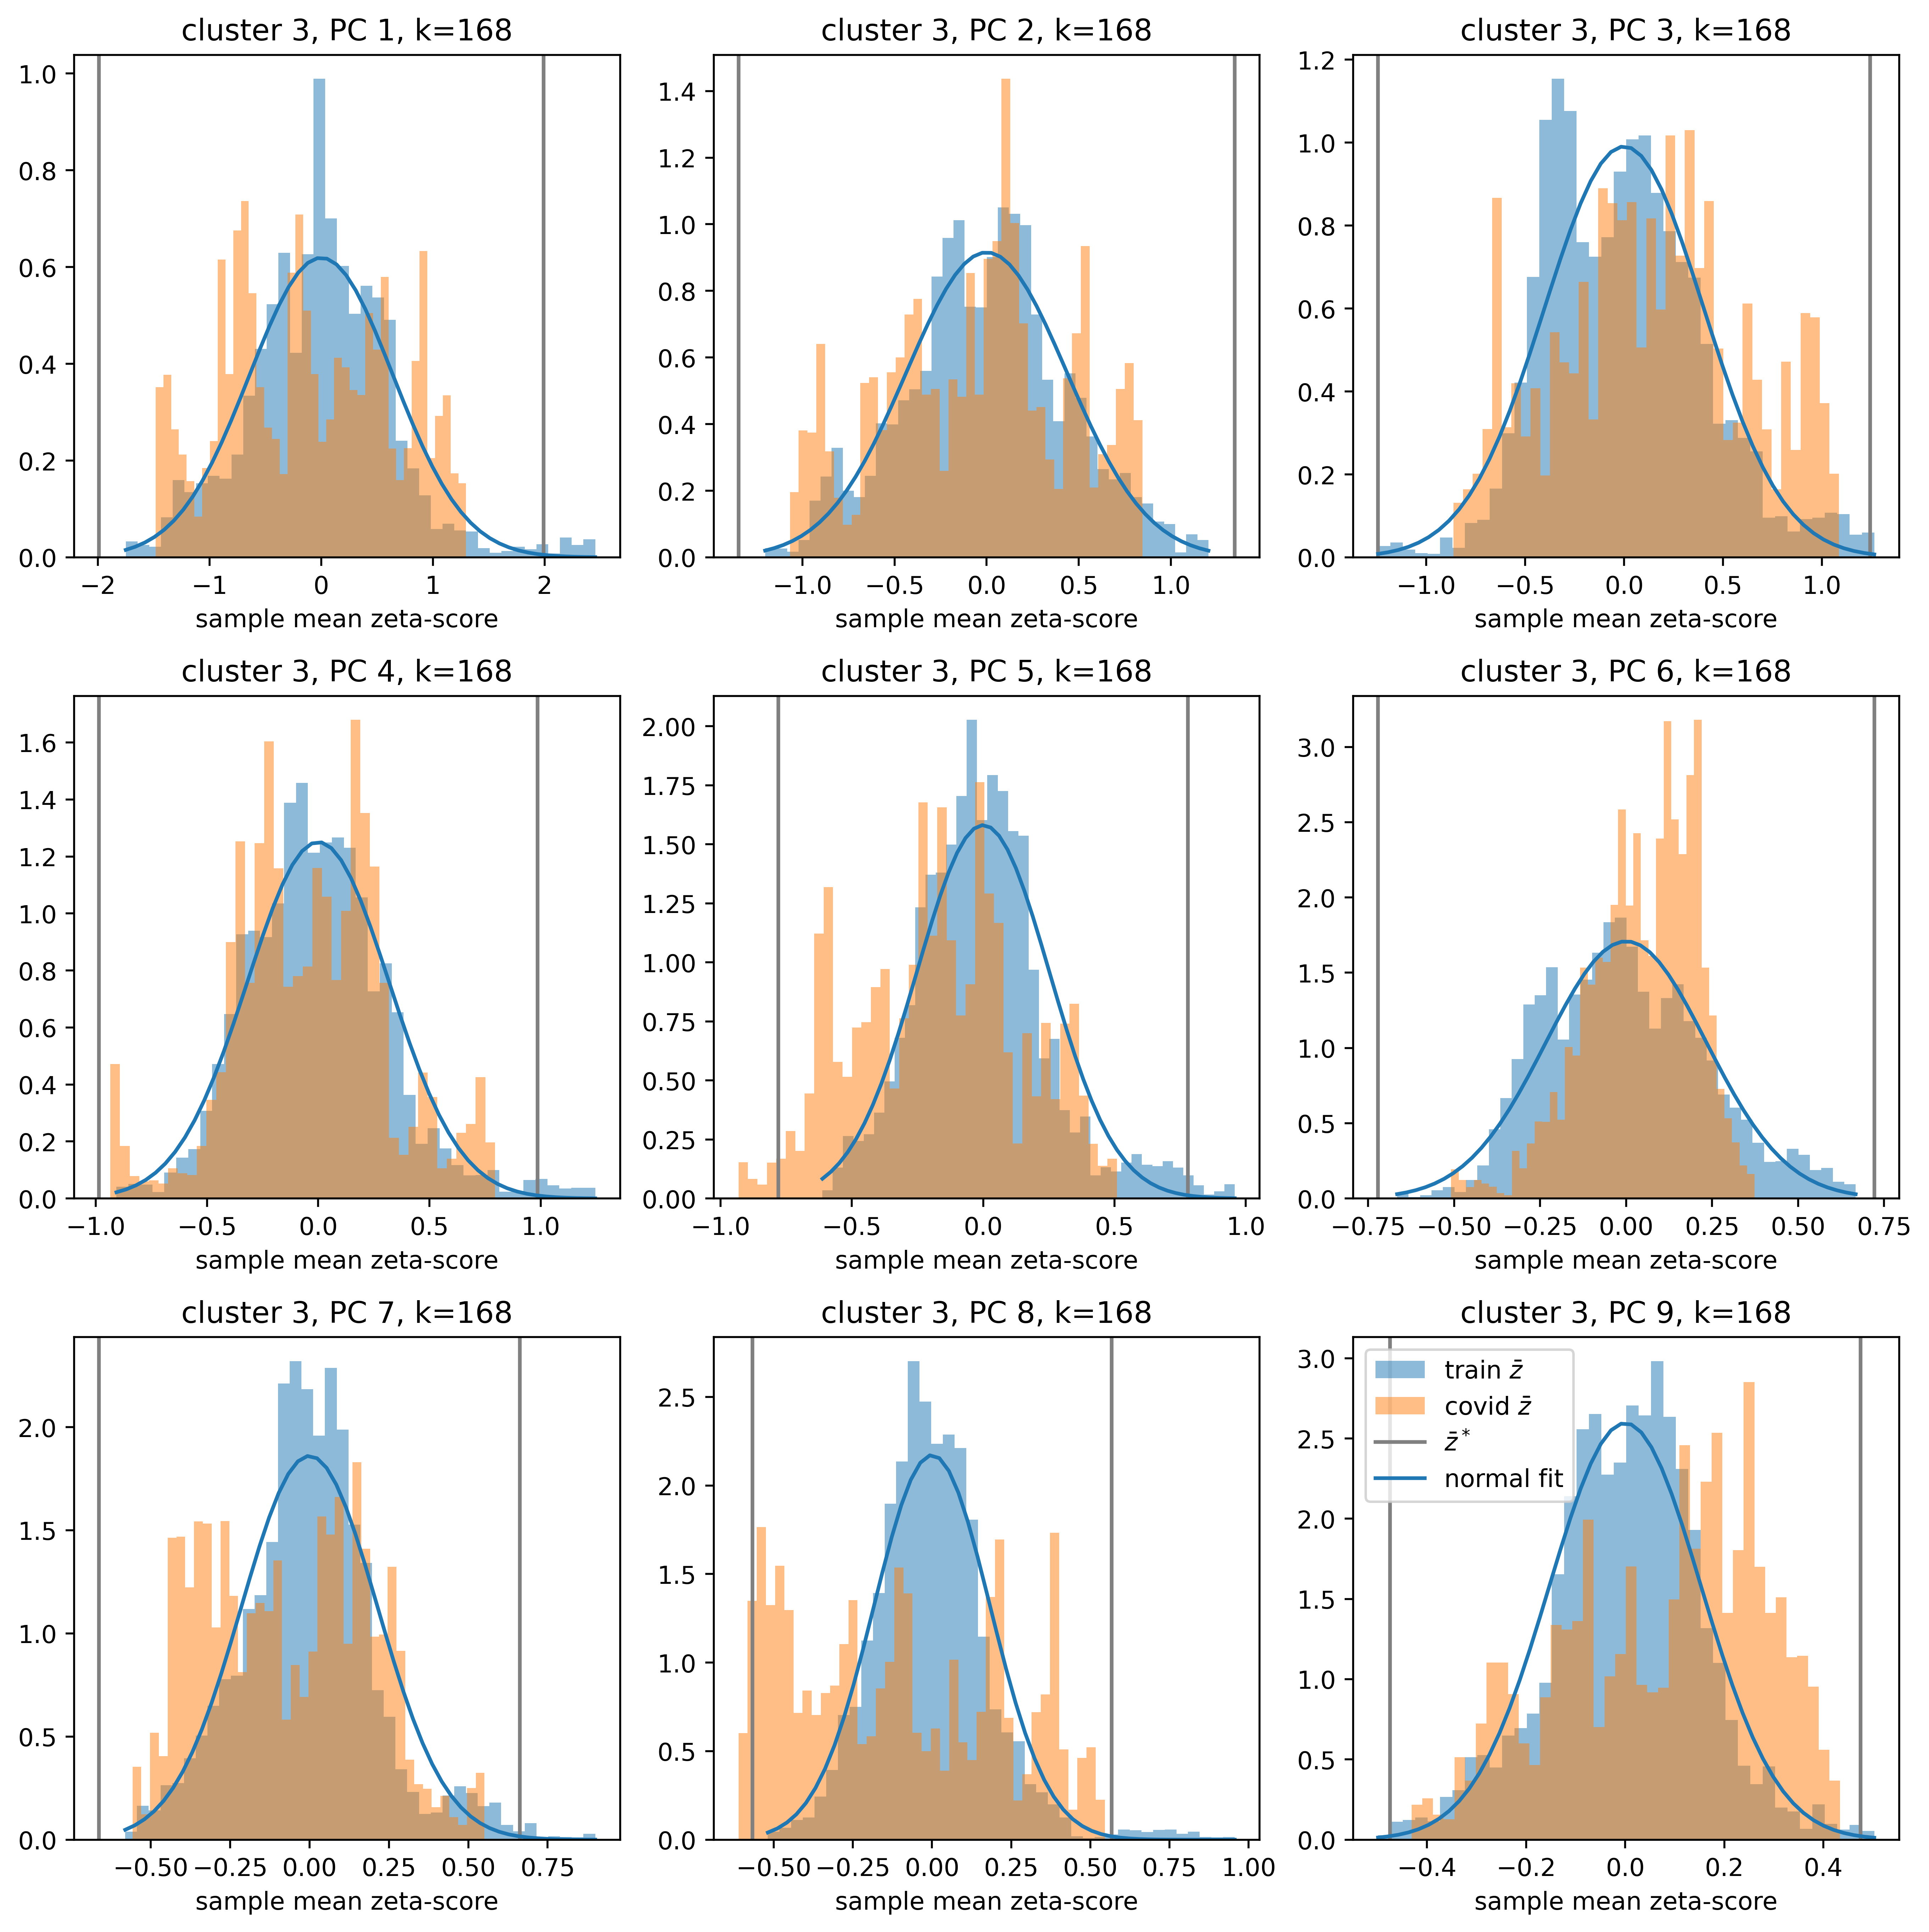

In [605]:
plt.figure(dpi=500, figsize=(11, 11))
# norm_means = [] this is just 0
norm_stds = []
for i in range(len(good_station_idxs)):
    plt.subplot(3, 3, i+1)
    # norm_means.append(np.mean(train_proj[:, i]))
    norm_stds.append(np.std(train_proj[:, i]))
    norm_crit_l = norm.ppf(alpha, loc=0, scale=norm_stds[-1])
    norm_crit_u = norm.ppf(1-alpha, loc=0, scale=norm_stds[-1])
    plt.hist(train_proj[:, i], bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar z$")
    # plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
    plt.hist(test_proj[:, i], bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar z$")
    plt.axvline(norm_crit_l, color="gray", label="$\\bar z^*$")
    plt.axvline(norm_crit_u, color="gray")
    plt.title(f"cluster {cluster_id}, PC {i + 1}, k={k}")
    plt.xlabel("sample mean zeta-score")
    l = np.linspace(min(train_proj[:, i]), max(train_proj[:, i]))
    # if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
    plt.plot(l, norm.pdf(l, loc=0, scale=norm_stds[-1]), label="normal fit")
plt.legend()
plt.tight_layout()

In [606]:
# from scipy.spatial.distance import mahalanobis
# mean = np.mean(train_zeta_avg_mat, axis=0)
# err = train_zeta_avg_mat - mean
# cov = err.T @ err / (err.shape[0] - 1)
# icov = np.linalg.inv(cov)
# train_mahalanobis_dist = np.empty(len(train_zeta_avg_mat))
# for i in range(len(train_zeta_avg_mat)):
#     train_mahalanobis_dist[i] = mahalanobis(train_zeta_avg_mat[i, :], mean, icov)
# test_mahalanobis_dist = np.empty(len(test_zeta_avg_mat))
# for i in range(len(test_zeta_avg_mat)):
#     test_mahalanobis_dist[i] = mahalanobis(test_zeta_avg_mat[i, :], mean, icov)

# plt.imshow(cov)

In [607]:
train_mahalanobis_dist

array([1.01149233, 1.04359419, 1.09089608, ..., 1.18002784, 1.18722405,
       0.44754824])

In [608]:
def l2_norm(vec, axis=None):
    return np.sqrt(np.sum(vec**2, axis=axis))

num_PCs = train_zeta_avg_mat.shape[1]
train_mahalanobis_dist = l2_norm(np.array([train_proj[:, i] / norm_stds[i] for i in range(num_PCs)]), axis=0)
test_mahalanobis_dist = l2_norm(np.array([test_proj[:, i] / norm_stds[i] for i in range(num_PCs)]), axis=0)
train_mahalanobis_dist, test_mahalanobis_dist

(array([0.42067839, 0.54338431, 0.53006995, ..., 1.17590373, 1.15253006,
        1.0726333 ]),
 array([0.93062935, 1.07453446, 1.30605803, ..., 1.45847642, 1.46334026,
        1.12246951]))

In [609]:
def get_nd_cdf(n, radial_density=norm):
    """returns a function that, given a radius r, returns the probability
     of an observation being as close or closer to the origin in n dimensional
    space than r, assuming observations are drawn from a distribution centered
    at the origin and all of whose radial cross sections have density function `radial_density`"""
    stop = 10
    num = 1000
    while True:
        radii = np.linspace(0, stop, num)
        cdf = np.zeros_like(radii)
        for i, r in enumerate((radii[1:] + radii[:-1]) / 2):
            dr = radii[i + 1] - radii[i]
            shell = radial_density.pdf(r) * r**(n - 1)
            cdf[i + 1] = shell * dr + cdf[i]
        cdf /= max(cdf)

        radial_pdf = cdf[1:] - cdf[:-1]
        if radial_pdf[-1] < 0.001 * max(radial_pdf):
            break
        else:
            stop *= 2
            num *= 2
    return interpolate.interp1d(radii, cdf, bounds_error=True)

In [610]:
from scipy import stats
# df = 2
cdf = get_nd_cdf(num_PCs, radial_density=norm)

train_probs, test_probs = (1 - cdf(abs(train_mahalanobis_dist))), (1 - cdf(abs(test_mahalanobis_dist)))

Text(0.5, 0, 't')

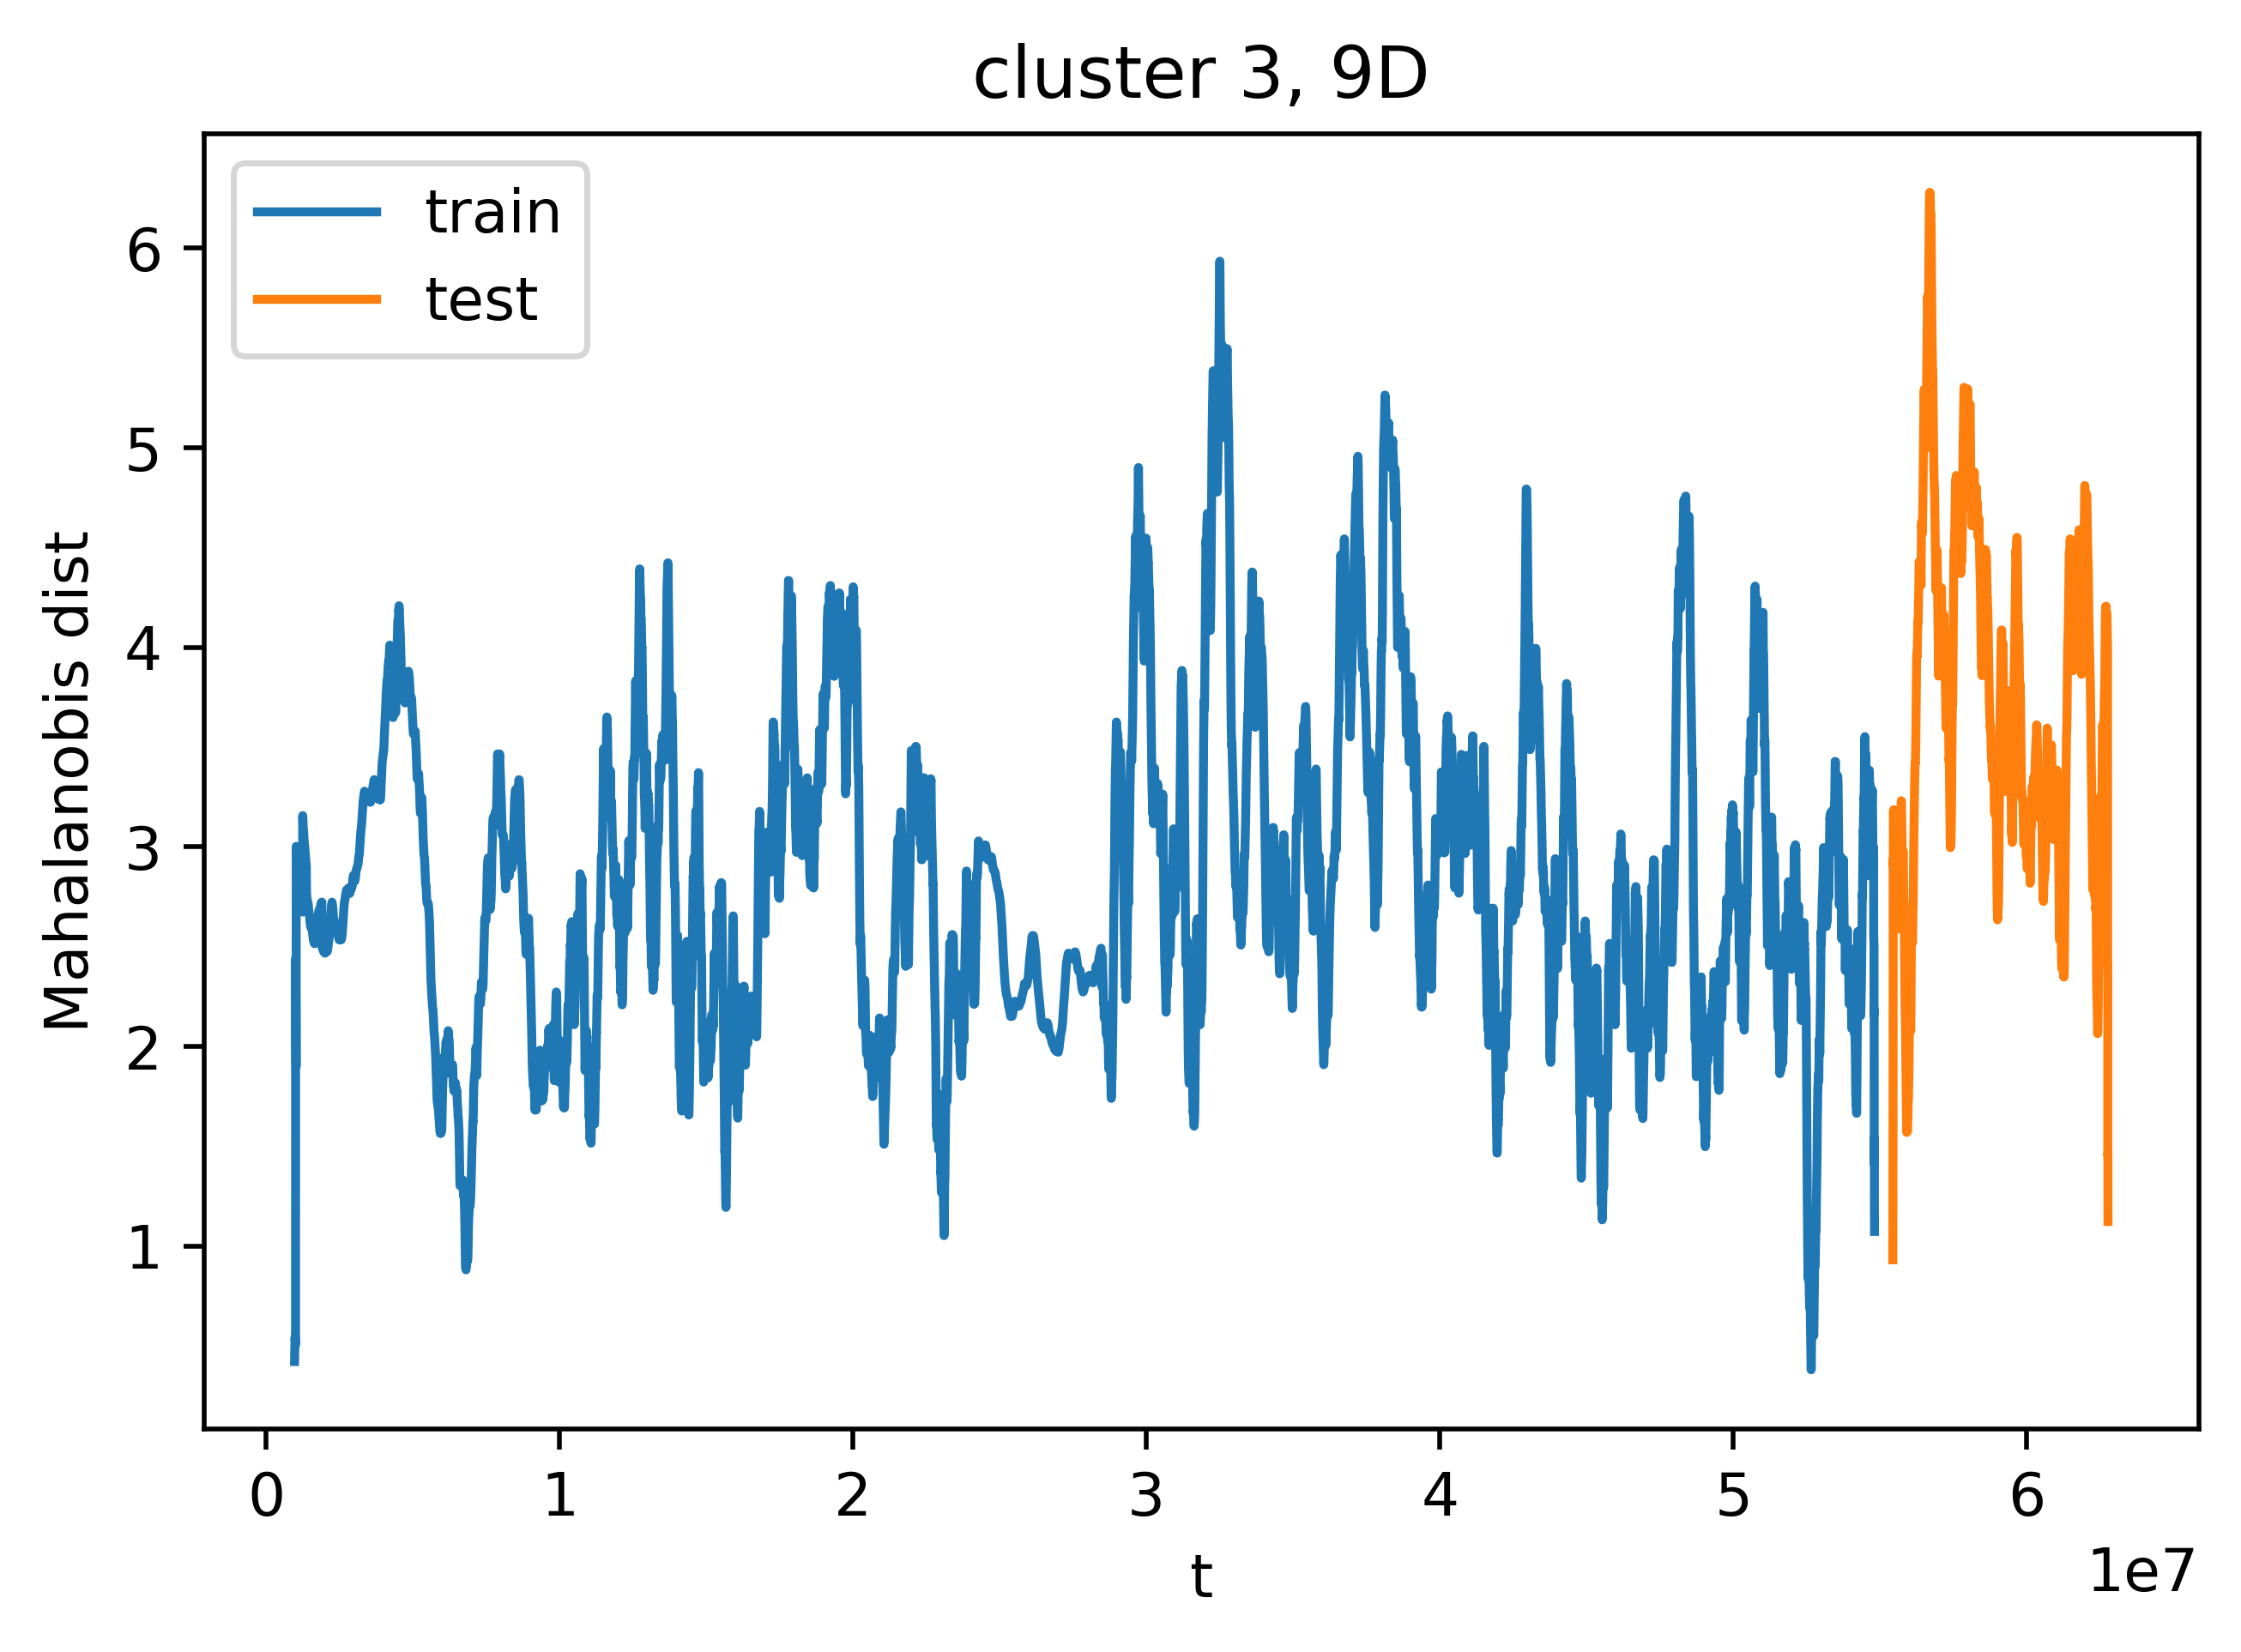

In [611]:
plt.figure(dpi=500)
plt.title(f"cluster {cluster_id}, {num_PCs}D")
plt.plot(all_train_ts, train_mahalanobis_dist, label="train")
plt.plot(all_test_ts, test_mahalanobis_dist, label="test")
plt.legend()
plt.ylabel("Mahalanobis dist")
plt.xlabel("t")

Text(0.5, 0, 't')

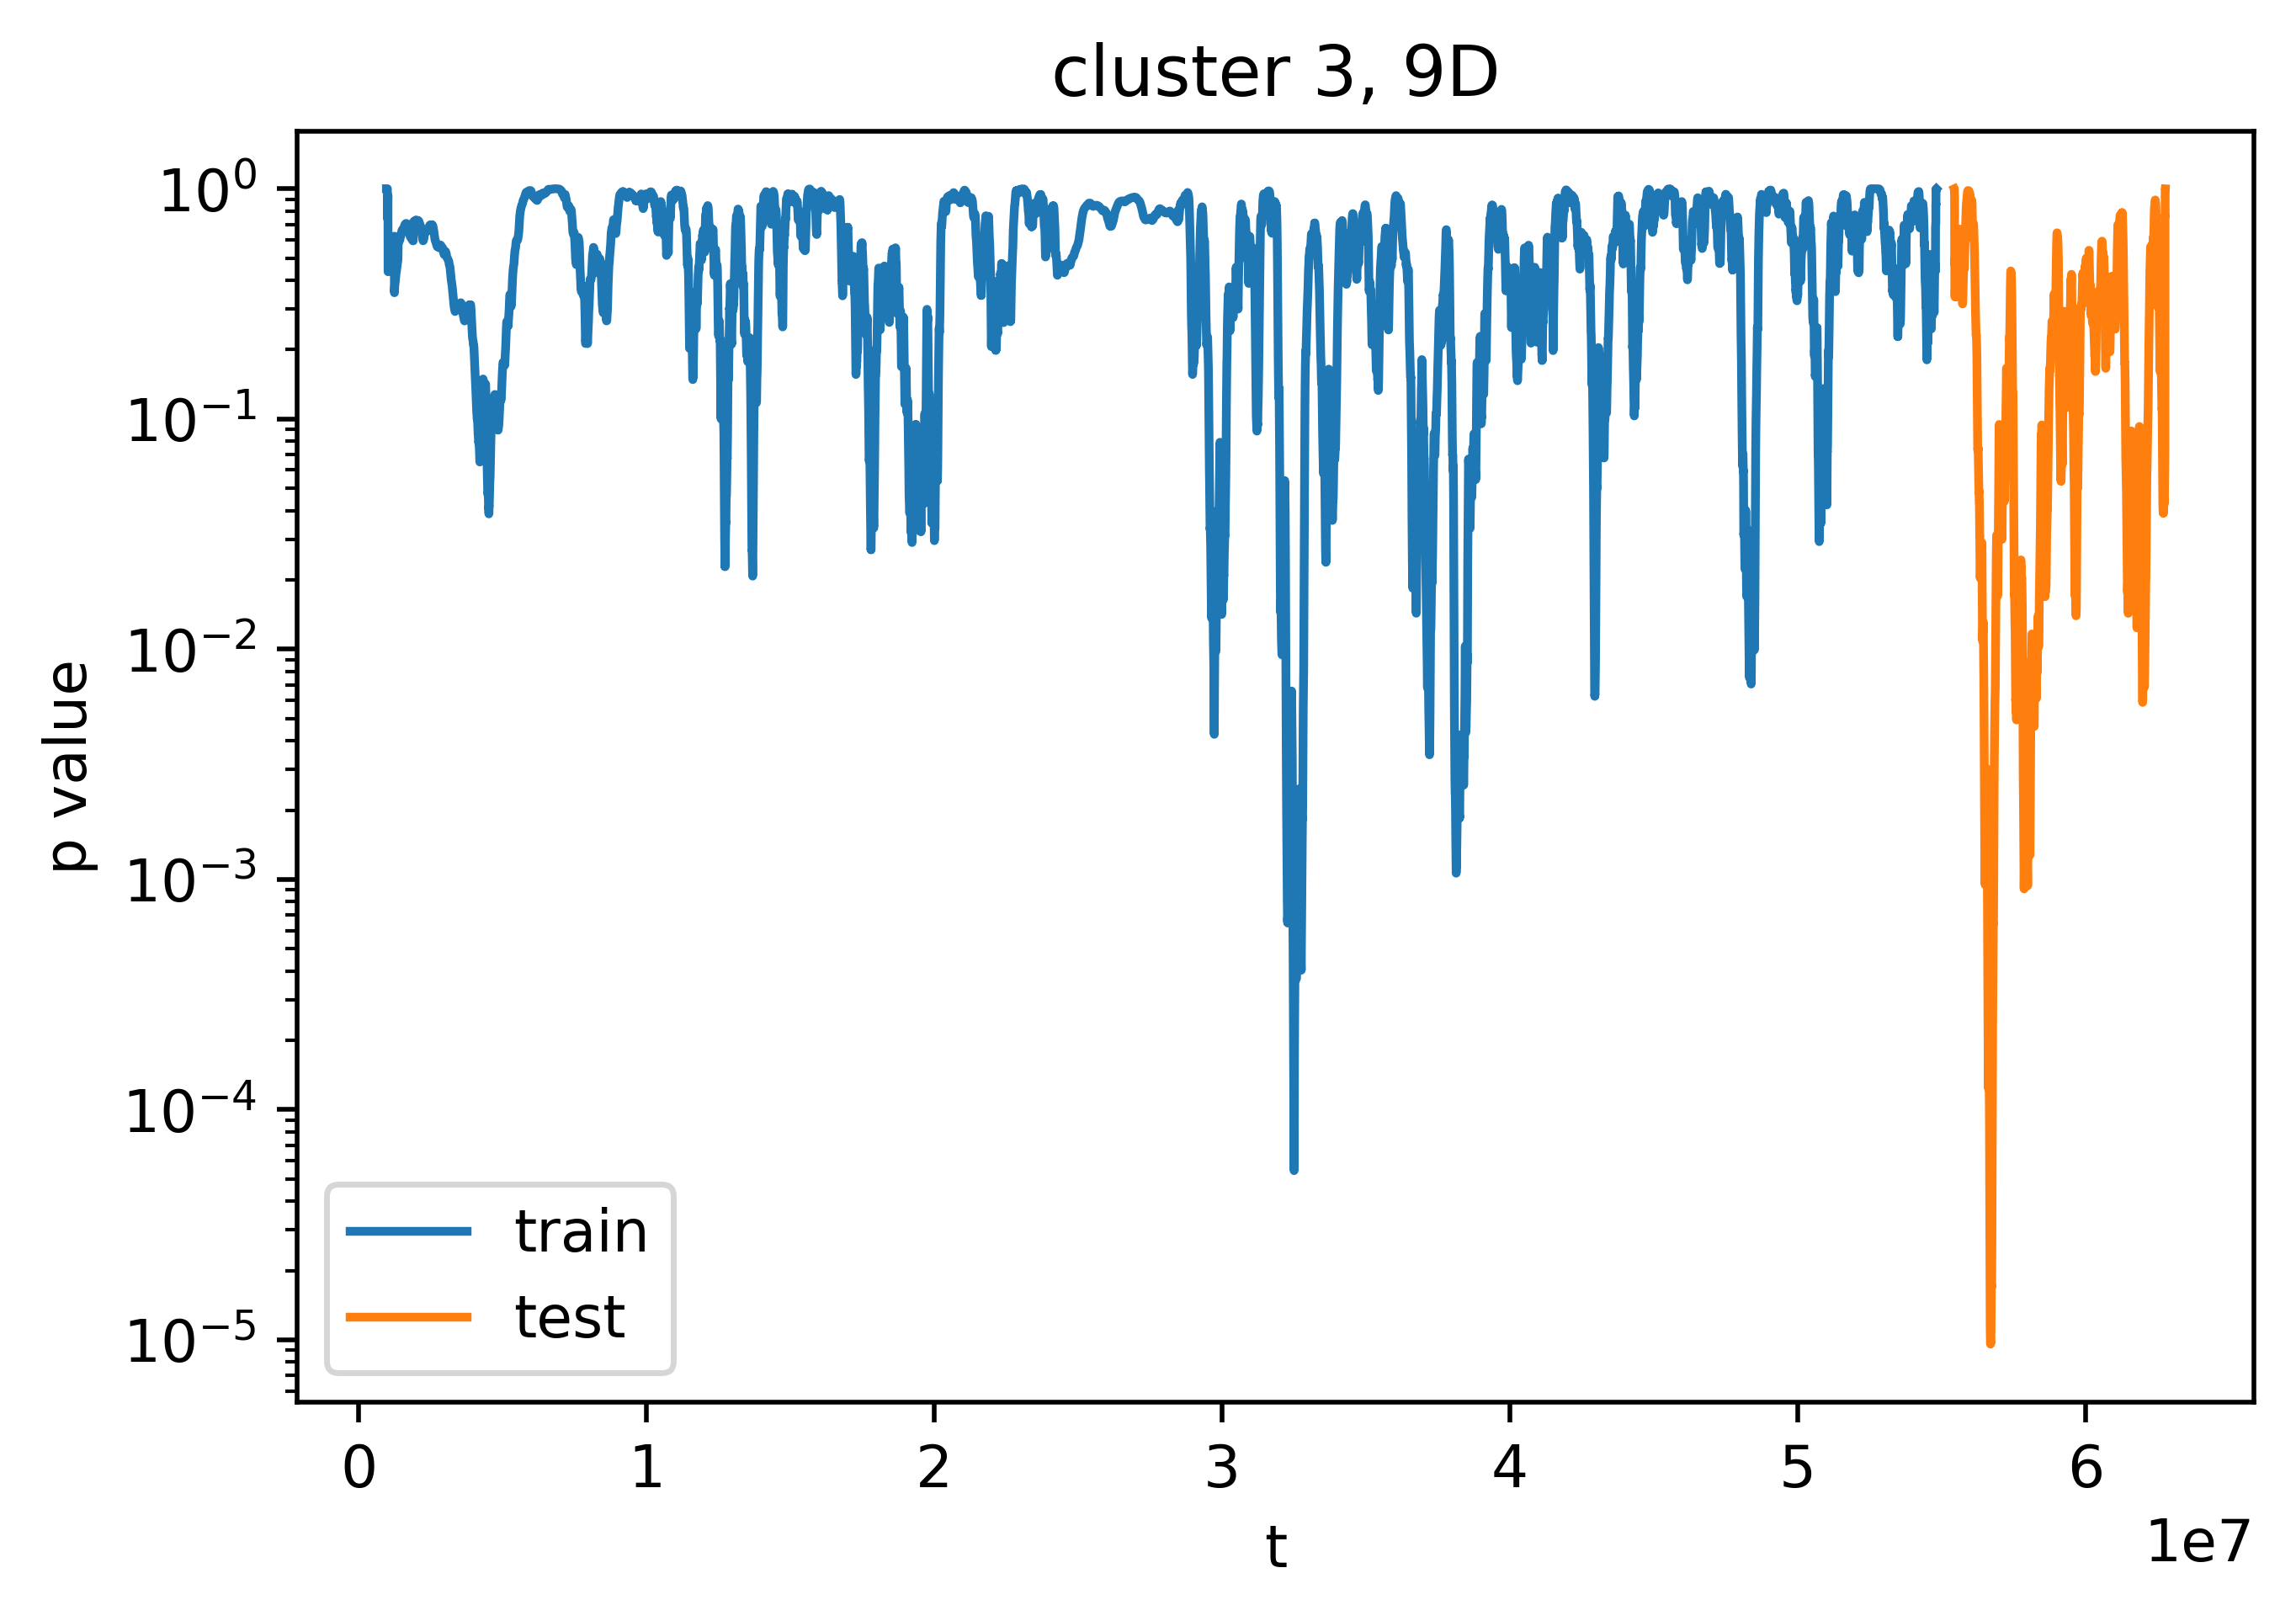

In [612]:
plt.figure(dpi=500)
plt.title(f"cluster {cluster_id}, {num_PCs}D")
plt.plot(all_train_ts, train_probs, label="train")
plt.plot(all_test_ts, test_probs, label="test")
plt.legend()
plt.ylabel("p value")
plt.semilogy()
plt.xlabel("t")

Text(0.5, 0, 'p value')

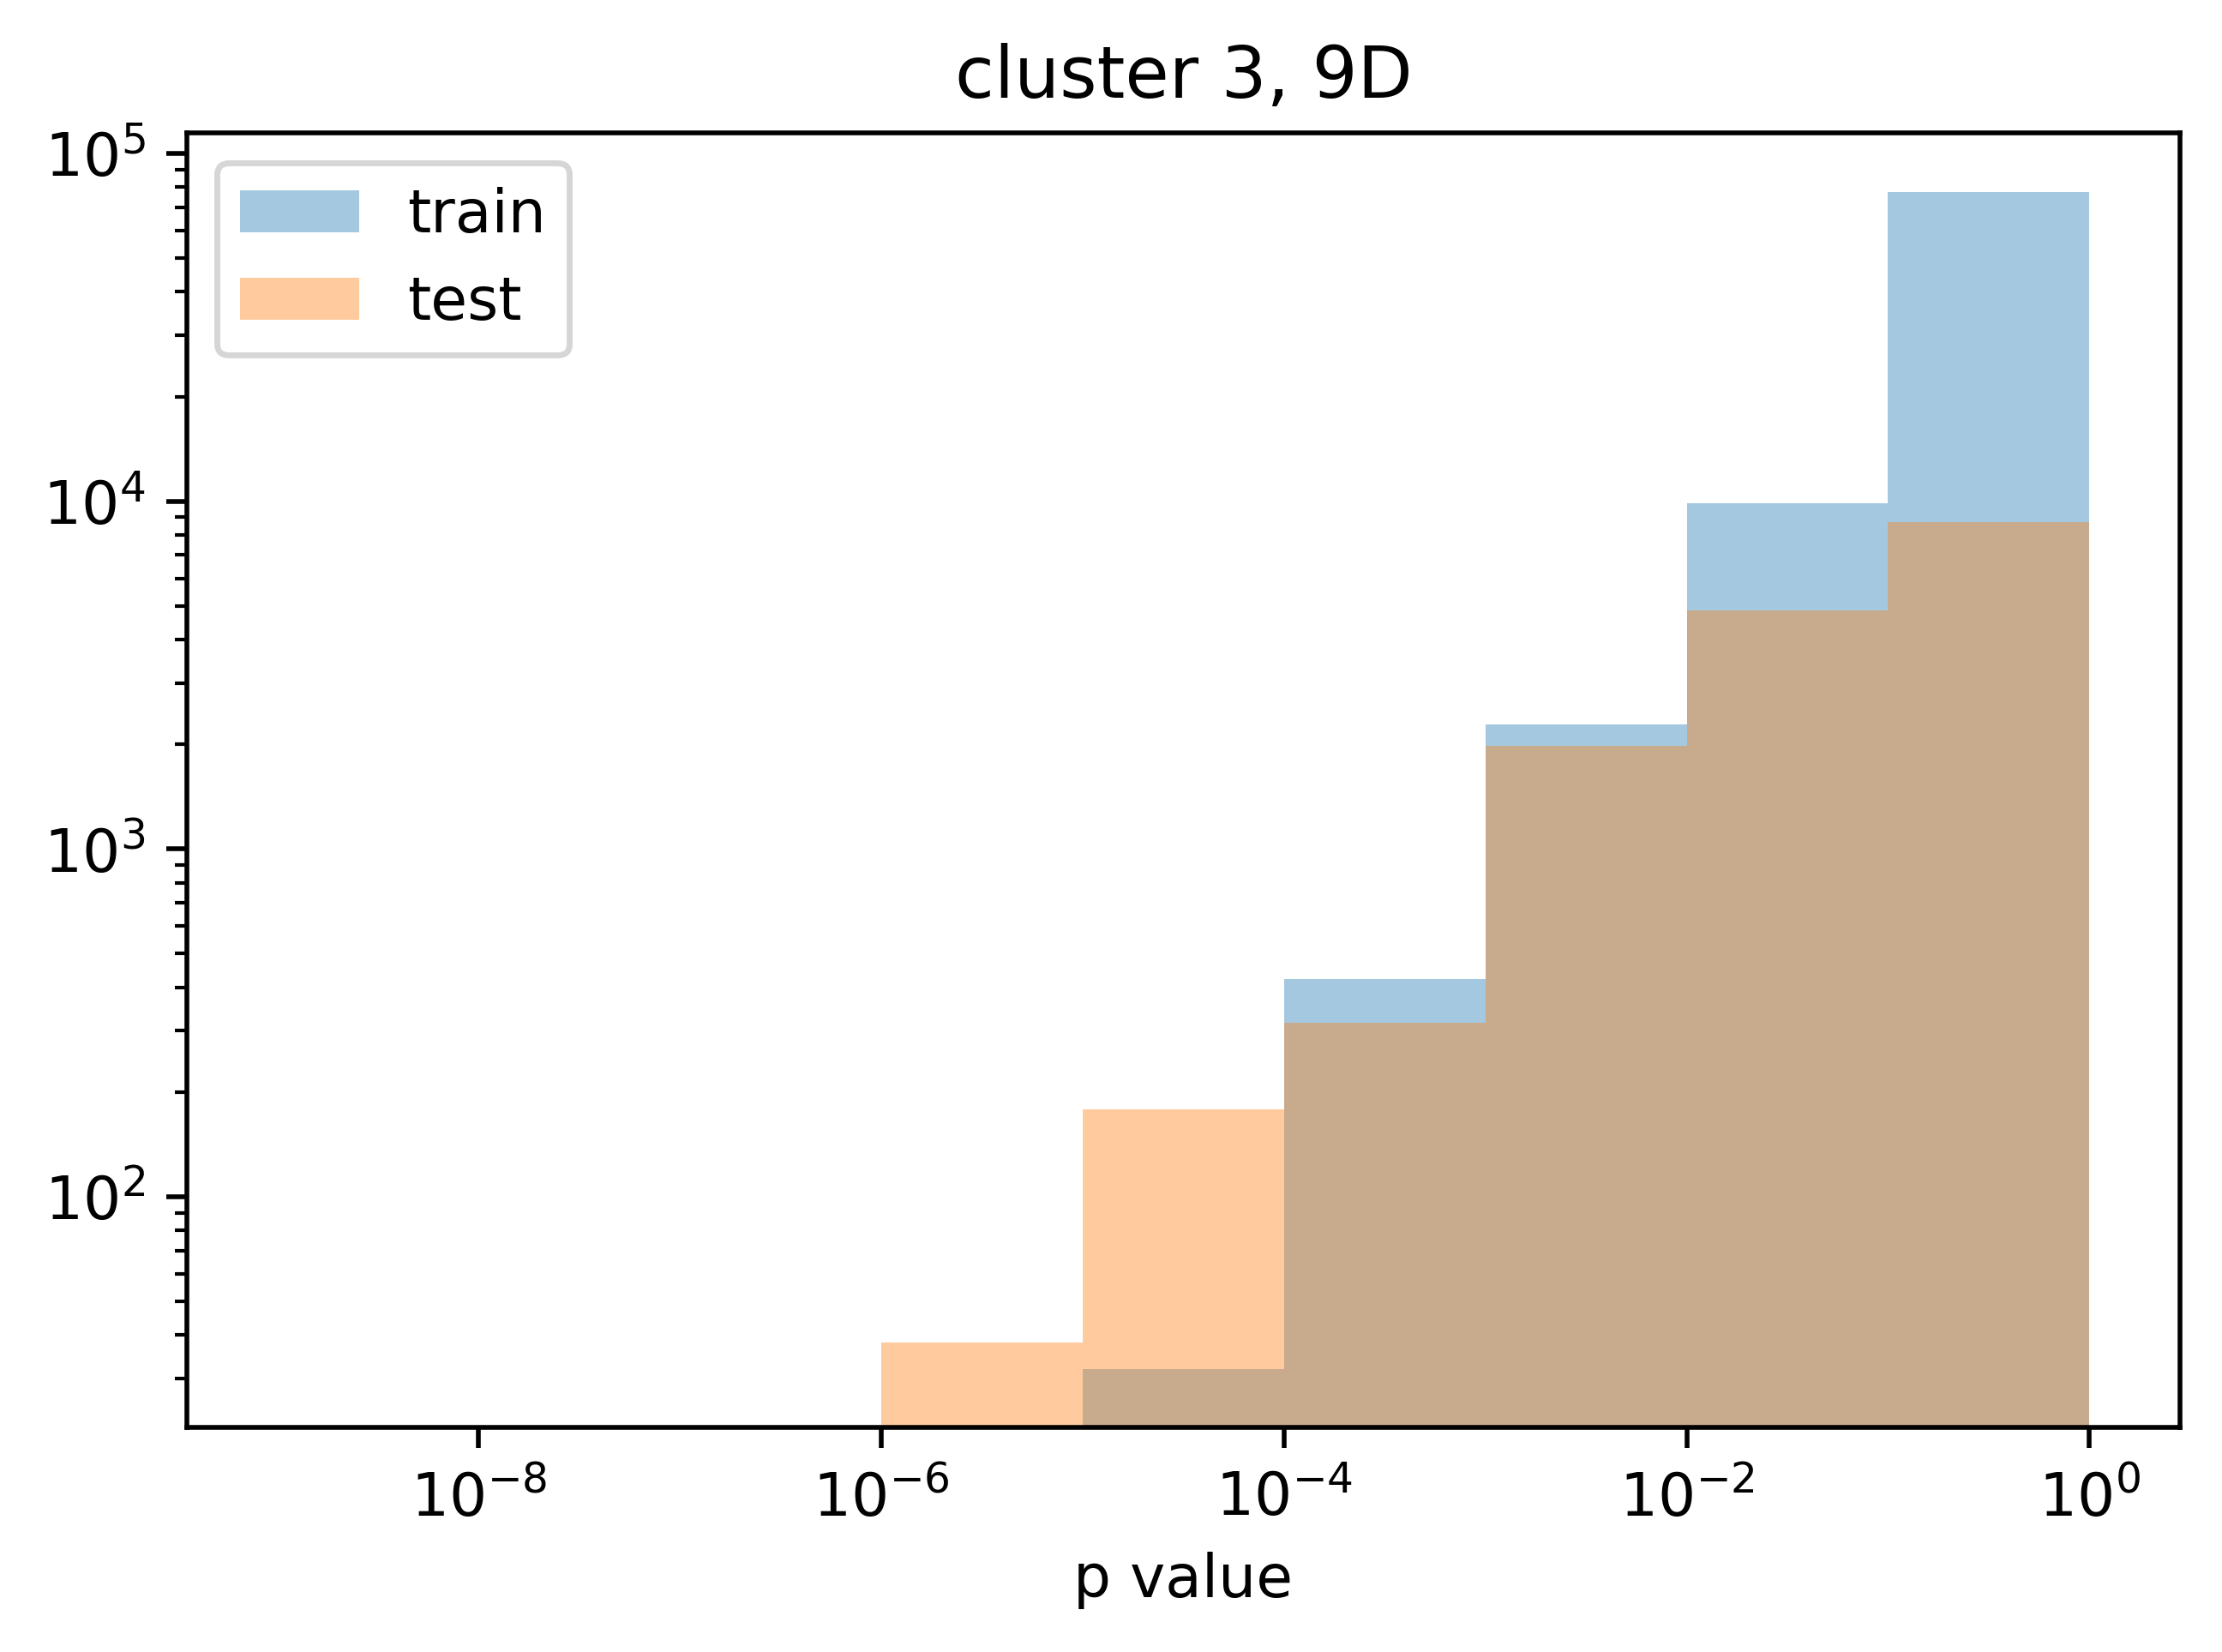

In [615]:
plt.figure(dpi=500)
plt.title(f"cluster {cluster_id}, {num_PCs}D")
bins = [0] + [10.0**i for i in range(-9, 1)]
plt.hist(train_probs, label="train", alpha=0.4, bins=bins, density=False) #, bins=[0, 0.001, 0.01, 0.1, 0.5, 1])
plt.hist(test_probs, label="test", alpha=0.4, bins=bins, density=False) #, bins=[0, 0.001, 0.01, 0.1, 0.5, 1])
plt.legend()
plt.semilogx()
plt.semilogy()
plt.xlabel("p value")

In [614]:
min(train_probs), min(test_probs)

(5.434380556346152e-05, 9.586536067085483e-06)